# Import
Block for storing all imported libraries.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import neuralfoil as nf
import aerosandbox as asb
import aerosandbox.numpy as np

# Constants
A block for storing all constants required during the calculation. Separated into a distinct block for easier access to them.

First of all we must define the characteristics that we want for the future UAV. In this field we can use "House of quality" by ... [1]. With help of this method, we can identify the most necessary parameters for the future design.

**Add some information about house of quality and "build" it.** Create parametric research and link this to house of quality. Show how important define all parametrs befor design (or this is first step of design)

[1] Akao, Y. (1990). Quality Function Deployment: Integrating Customer Requirements into Product Design.

In [ ]:
class DesignConstants:
    g = 9.81 

    eng_q = 2 # Number of engines
    con_cell_num = 6 # Number of cells in series in one battery string
    cell_U = 4.2 # Nominal cell voltage, V
    prop_D = 22 # Propeller diameter, inches

    LD_ratio_cruise = 14 # Cruise lift-to-drag ratio (L/D)
    prop_efficiency = 0.75 # Propeller efficiency η_p
    battery_specific_energy = 216 # Battery specific energy, Wh/kg
    payload_mass = 1.5 # Payload mass, kg
    flight_time = 90 # Required flight time, minutes
    flight_time_hr = flight_time / 60 # Required flight time, hours
    cruise_speed = 90 # Cruise speed, km/h
    cruise_speed_ms = cruise_speed / 3.6 # Cruise speed, m/s
    takeoff_mass_reserve = 1.07 # Take-off mass margin factor
    battery_mass_reserve = 1.1 # Battery mass margin factor
    k = 0.3 # Empirical coefficient for propeller mass formula
    n = 2.3 # Empirical exponent for propeller mass formula
    prop_fasteners = 0.015 # Additional mass of propeller fasteners per powerplant
    e = 0.78 # Oswald efficiency factor
    k_structure = 0.3 # Structure mass fraction

    stall_speed = 55 # stall speed (kph)
    air_density_sea_level = 1.225 # air density on takeoff (sea level)
    max_lift_coefficient_stat = 1.4 # maximum wing lift coefficient (statistically)
    min_lift_coefficient_stat = -0.8 # minimum wing lift coefficient (from the aerofoil polar)
    derivative_max_lift_coefficient_stat = 5.25 # derivative of max lift coefficient (by statistic)
    WP = 0.1 # energy armament (by prototype)

    # Battery parameters
    series_cells_n = 6
    parallel_cells_n = 4 
    cell_U_min = 3
    cell_U_max = 4.2
    cell_capacity_nom_A = 4.2 
    cell_capacity_nom_W = 15.5
    max_current_cell = 45
    cell_mass = 0.07
    battery_mass_coef = 1.12
    screws_n = 2
    blades_n = 2
    Kp = 0.0995

    screws_n = 2
    blades_n = 2
    Kp = 0.0995

    # 
    Re_cruise = 511979
    SwetS = 2 # According to the table from the sources
    AR = 8 # Aspect ratio (Presumably, need to correct or use Aerosandbox optimization)
    air_density_cruise = 1.1117
    dynamic_viscosity_cruise = 0.00001787
    prop_efficiency_cruise = 0.75
    battery_depth = 0.3

    # Wing parametrs
    taper_ratio = 0.57

    # Speed on transition
    Vy_hover = 0.0
    Vy_climb = 3.0
    Vy_ceiling = 0.5

    # Prop characteristics
    Vtip = 80  # м/с
    solidity = 0.1
    Cd_blade = 0.02
    induced_power_factor_hover = 1.15
    induced_power_factor_climb = 1.15
    # disc_loading_max_diameter = 0.246
    total_disc_area_max = 0.2463 * 2

    # Angels
    alpha_rotor_trans = 0

    # Wing aerodynamic
    wing_loading_optimum_airborne = 300  # Н/м²

    climbe_rate = 3 # m/s
    ceiling_rate_of_climb = 0.5 # m/s
    max_lift_coefficient = 1.4

    # Airfoil parameters
    number_point_on_chord = 30
    phi = math.radians(90 / (number_point_on_chord - 1))
    profile_thickness = 0.12
    profile_curv = 0.04
    max_curv_point = 0.4
    profile_max_lift_coefficient = 1.55

    # Wing characteristics
    wing_narrowing = 0.5
    sweep_angel_1_2 = 0
    angel_of_incedence = 0
    dihedral_angel = 0
    wing_tip_twist = 0

    drag_coefficient_constant = 0.045161009

    vertical_stab_aspect_ratio = 2

    # Геометрические параметры килей (примерные, будут масштабироваться)
    # Центральный киль (вверх)
    central_root_chord = 0.50
    central_tip_chord  = 0.25
    central_span       = 0.80   # высота киля

    # Боковые кили (вниз)
    side_root_chord = 0.40
    side_tip_chord  = 0.20
    side_span       = 0.60

    fraction_central = 0.40   # 40% общей площади — центральный киль вверх

## Zero approximation of takeoff mass
A very rough statistical estimate based only on payload mass [2]:

$$
m_{0}=5.147m_{пн}^{0.849}
$$

[2] Gudmundsson, S. (2013). General Aviation Aircraft Design.

In [ ]:
def calculate_zero_approximation_mass(payload_mass):
    """Calculate zero approximation of takeoff mass based on payload."""
    return 5.147 * payload_mass ** 0.849

Zero approximation of takeoff mass: 7.26199001085213
Zero approximation of takeoff weight: 71.2401220064594


## Calculation of takeoff mass
Next approximations of takeoff mass calculation need more parametrs, than just payload mass.
Structure mass can be calculated []:
$$\frac{m_{str}}{m_{0}}=0.3$$
**Where**:
- $m_{str}$ - Aircraft structural mass
- $m_{0}$ - Zero approximation mass

Required power []:
$$P_{req}=\frac{m_{0} \cdot g \cdot V}{\frac{L}{D} \cdot n_{prop}}$$
**Where**:
- $P_{req}$ - Total required engine power, W
- $V$ - Cruise speed, m/s
- $\frac{L}{D}$ - Aerodynamic quality (lift-to-drag ratio)
- $n_{prop}$ - Propeller efficiency

Engine mass []:
$$m_{eng}=0.889P_{max}^{-0.288}U_{max}^{0.1588}$$
**Where**:
- $m_{eng}$ - Engine mass, kg
- $P_{max}$ - max continuous power of one motor, W
- $U_{max}$ - Maximum battery voltage, V

Propeller mass []:
$$m_{prop}=k \cdot D^{n}$$
**Where**:
- $m_{prop}$ - Propeller mass
- $D$ - Propeller diameter, inches

Battery mass []:
$$m_{bat}=\frac{E_{req}}{p_{bat}}=\frac{P_{req} \cdot t_{flight}}{p_{bat}}$$
**Where**:
- $m_{bat}$ - Battery mass
- $E_{req}$ - 
- $p_{bat}$ - Battery specific energy, Wh/kg
- $t_{flight}$ - Time of flight

First approximation takeoff mass []:
$$m_{0}^{(i+1)}=m_{str}^{(i)}+m_{eng}^{(i)}+m_{bat}^{(i)}+m_{payload}+m_{eq}$$
**Where**:
- $m_{0}^{(i+1)}$ - First approximation UAV mass

The difference between the zeroth and first approximation []:
$$e=\frac{m_{0}^{(i+1)}-m_{0}^{(i)}}{m_{0}^{(i+1)}} \cdot 100%$$


In [ ]:
def iterate_takeoff_mass(const: DesignConstants,
                         tol: float = 0.5,   # % convergence
                         max_iter: int = 50) -> dict:
    """
    Iterative mass convergence.
    Returns dict with final values and iteration history.
    """
    m0 = zero_approximation_mass(const.payload_mass)
    g = 9.81
    history = []

    for i in range(max_iter):
        W0 = m0 * g
        V_cruise = const.cruise_speed_kph / 3.6

        # Required cruise power
        P_req = W0 * V_cruise / (const.LD_cruise * const.prop_efficiency)
        P_per_motor = P_req / const.n_engines

        # Motor mass (statistical, 6S)
        U_pack = 6 * 4.2
        m_motor_one = 0.889 * (P_per_motor ** -0.288) * (U_pack ** 0.1588)

        # Propeller mass
        m_prop_one = const.k_prop * (const.prop_diameter_in ** const.n_prop) / 1000.0

        # Powerplant total
        m_powerplant = const.n_engines * (m_motor_one + m_prop_one) + const.prop_fasteners_mass

        # Battery
        E_req_wh = P_req * (const.flight_time / 60.0)
        m_battery = (E_req_wh / const.battery_specific_energy) * const.battery_mass_margin

        # Structure & equipment
        m_structure = const.k_structure * m0
        m_eq = const.m_equipment_fixed

        # New mass estimate
        m0_new = (const.payload_mass + m_structure + m_eq + m_powerplant + m_battery)
        m0_new *= const.takeoff_mass_margin

        error = abs(m0_new - m0) / m0_new * 100.0
        history.append({
            "iter": i+1, "m0_kg": round(m0, 4), "m0_new_kg": round(m0_new, 4),
            "error_%": round(error, 3), "P_req_W": round(P_req, 1),
            "m_battery_kg": round(m_battery, 4), "m_powerplant_kg": round(m_powerplant, 4)
        })

        if error < tol:
            print(f"Mass convergence in {i+1} iterations (Δ < {tol} %)")
            break

        m0 = m0_new

    result = history[-1].copy()
    result.update({
        "final_m0_kg": m0_new,
        "history_df": pd.DataFrame(history),
        "P_req_cruise_W": P_req,
        "battery_mass_kg": m_battery,
        "powerplant_mass_kg": m_powerplant
    })
    return result

After obtaining the function for calculating the mass of the spacecraft, you need to call it and retrieve the final data. The function will perform as many iterations as necessary until it achieves a 1% difference in mass.

# Step 2: Definition of binding parameters
## Block 1
This block calculates the wing loading parameters based on the given input parameters.

### Calculation 1

SI units are used in the calculations, so it is necessary to convert the speed to SI units:
$$V_{stall} = \frac{V_{kph}}{3.6}$$
**Where**:
- $V_{kph}$ - Stall velocity in kilometer per hour

Dynamic pressure on stall is calculated using the following formula []:
$$q_{stall} = \frac{1}{2} \rho_{stall} V_{stall}^{2}$$
**Where**:
- $\rho$ - Air density on sea level

Wing loading on stall  is calculated using the following formula []:
$$\frac{W}{S} = q_{stall} C_{L}$$
**Where**:
- $C_{L}$ - Lift coefficient statistics for such UAVs

In [12]:
stall_speed_ms = stall_speed / 3.6 # stall speed (m/s)
dynamic_pressuare = 0.5 * air_density_sea_level * stall_speed_ms ** 2 # Dynamic pressuare on stall 
wing_loading = max_lift_coefficient_stat * dynamic_pressuare # Wing loading on stall

print("Dynamic pressuare on stall:", dynamic_pressuare)
print("Wing loading on stall:", wing_loading)

Dynamic pressuare on stall: 142.9639274691358
Wing loading on stall: 200.1494984567901


### Calculation 2
We need to calculate requred wing area by formula []:
$$S_{wing} = \frac{W_{0}}{W/S}$$
**Where**:
- $W_{0}$ - Takeoff weight of UAV

In [13]:
take_off_weight = m0_final * g
S_wing = wing_loading / take_off_weight

print("Wing area (S):", S_wing)

Wing area (S): 2.660598482094547


## Block 2: Сalculation of battery parameters
After previos calculation battery parametrs need to be calculated. For this need to be a lot of input parametrs.

Add this block later)))

In [ ]:
battery_weight = m_battery * g

cell_total = series_cells_n * parallel_cells_n
pack_cell_U_min = series_cells_n * cell_U_min
pack_cell_U_max = series_cells_n * cell_U_max
pack_cell_U = series_cells_n * cell_U
pack_cell_capacity_nom_A = parallel_cells_n * cell_capacity_nom_A
pack_cell_capacity_nom_W = parallel_cells_n * cell_capacity_nom_W
pack_max_current_cell = parallel_cells_n * max_current_cell
pack_cell_mass = cell_total * cell_mass * battery_mass_coef
battery_pack_q = 1
total_battery_mass = pack_cell_mass * battery_pack_q
total_battery_capacity = battery_pack_q * pack_cell_capacity_nom_A

max_cell_q = battery_weight / battery_mass_coef / cell_mass

print("Battery capacity:", pack_cell_capacity_nom_A, "A*h")
print("Battery mass:", total_battery_mass)
print("The capacity of all batteries when connected in parallel:", total_battery_capacity, "A*h")

NameError: name 'battery_mass' is not defined

## Block 3
### Input value 3

In [ ]:
fric_coef = 0.74/(Re_cruise**0.2)

### Calculation 3
This block calculates the take-off weight required to achieve the specified flight range.

Drag coefficient on zero lift []:
$$C_{D0} = C_{fe} \frac{S_{wet}}{S_{ref}}$$
**Where**:
- $\frac{S_{wet}}{S_{ref}}$ - By statistic for this type of UAVs

Induced drag coefficient is calculate using this formula []:
$$K = \frac{1}{\pi AR e}$$
**Where**:
- $AR$ - Wing aspect ratio
- $e$ - Oswald coefficient

Available wing loading in cruise mode []:
$$\frac{W}{S}_{cruise} = \frac{W}{S} \cdot \frac{W_{cruise}}{W_{0}}$$
**Where**:
- $\frac{W_{cruise}}{W_{0}}$ - ?

Dynamic pressuare on cruise []:
$$q_{cruise} = \frac{1}{2} \rho_{cruise} V_{cruise}^{2}$$

Aerodynamic quality on cruise []:
$$\frac{L}{D} = \frac{1}{\frac{q_{cruise} C_{D0}}{W/S} + (W/S) \frac{K}{q_{cruise}}}$$

In [ ]:
zero_lift_drag_cruise = SwetS * fric_coef
induced_drag_factor_K = 0.3183 / AR / 0.78
wing_loading = wing_loading * 1
dynamic_pressuare_cruise = 0.5 * air_density_cruise * cruise_speed_ms ** 2
# aerodynamic_quality = 1 / ((dynamic_pressuare_cruise*Cd0 / wing_loading) * (wing_loading * K / dynamic_pressuare_cruise))
CL_opt = np.sqrt(zero_lift_drag_cruise / induced_drag_factor_K)
CD_opt = zero_lift_drag_cruise + induced_drag_factor_K * CL_opt**2
aerodynamic_quality = CL_opt / CD_opt

eng_efficiency = prop_efficiency * 0.95
MbatM0 = total_battery_mass / m0_final
payload_weight = payload_mass * g

print(zero_lift_drag_cruise)
print("Cruise wing loading:", wing_loading, "H/m2")
print("Cruise dynamic pressuare:", dynamic_pressuare_cruise, "H/m2")
print("Aerodynamic quality L/D:", aerodynamic_quality)
print("The ratio of the battery mass to the total mass of the UAV over a given period of time:", MbatM0)

0.1067606688226137
Cruise wing loading: 200.1494984567901 H/m2
Cruise dynamic pressuare: 347.40625 H/m2
Aerodynamic quality L/D: 6.77545299895771
The ratio of the battery mass to the total mass of the UAV over a given period of time: 0.17019432195293874


## Block 4

### Calculation 4

In [ ]:
wingspan = np.sqrt(AR * S_wing)
root_chord_lenght = (2 * S_wing) / (wingspan * (1 + taper_ratio))
tip_chord_lenght = taper_ratio * root_chord_lenght
# tip_chord_lenght = wingspan * root_chord_lenght
MAC = (2/3) * root_chord_lenght * (1 + taper_ratio + taper_ratio ** 2) / (1 + taper_ratio)

print(f"Wingspan: {wingspan:.3f} m")
print(f"Lenght of middle aerodynamic chord: {MAC:.3f} m")

Wingspan: 3.842 m
Lenght of middle aerodynamic chord: 0.492 m


# Step 3: Constant analysis

## VTOL UAV Constraint Diagram

### Fixed-Wing Mode

#### Stall speed
Wing loading for stall speed:

$$
\frac{W}{S} = \frac{1}{2} \rho V_s^2 C_{L_{\text{max}}}
$$

**Where:**
- $W/S$ = Wing loading (N/m²)
- $V_s$ = Stall speed (m/s)
- $C_{L_{\text{max}}}$ = Maximum lift coefficient
- $\rho$ = Air density (kg/m³)

#### Maximum Speed Constraint
Power loading for maximum speed:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{1}{2} \rho V_{\text{max}}^3 \frac{C_{D_0}}{W/S} + \frac{2K}{\rho V_{\text{max}}} \frac{W}{S} \right)
$$

**Where:**
- $\eta_p$ = Propeller efficiency
- $V_{\text{max}}$ = Maximum speed (m/s)
- $C_{D_0}$ = Zero-lift drag coefficient
mb rate (Tessure (Pa)
- $\theta$ = Tilt angle (degrees)
- $V$ = Transition speed (m/s)
- $k_i$ = Induced power correction factor

#### Rate of Climb Constraint
Power loading for climb rate:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{V_c}{V} + \frac{qC_{D_0}}{W/S} + \frac{K}{q} \frac{W}{S} \right)V
$$

**Where:**
- $V_c$ = Climb rate (m/s)
- $V$ = Flight speed (m/s)
- $q = \frac{1}{2}\rho V^2$ = Dynamic pressure (Pa)


The maximum rate of climb speed for the given wing loading:
$$
V_{\text{climb}} = \sqrt{\frac{2 \cdot (W/S)}{\rho}} \cdot \left( \frac{K}{C_{D_0}} \right)^{1/4}
$$

**Where:**
- $V_{\text{climb}}$ = Best climb speed (m/s)
- $W/S$ = Wing loading (N/m²)
- $\rho$ = Air density (kg/m³)
- $K$ = Induced drag factor
- $C_{D_0}$ = Zero-lift drag coefficient

#### Turn Constraint
Thrust-to-weight ratio for turn:

$$
\frac{T}{W} = q \left( \frac{C_{D_0}}{W/S} + \frac{K n^2}{q^2} \frac{W}{S} \right)
$$

Power loading for turn:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{T}{W} \cdot V \right) = \frac{1}{\eta_p} \left( q V \frac{C_{D_0}}{W/S} + \frac{K n^2 V}{q} \frac{W}{S} \right)
$$

**Where:**
- $T/W$ = Thrust-to-weight ratio
- $n$ = Load factor
- $q = \frac{1}{2} \rho V^2$ = Dynamic pressure (Pa)

#### Transition Mode Constraint

Power loading during transition:

$$
\frac{P}{W} = \frac{k_i}{\sin(\theta_{tilt})} \sqrt{\frac{-V_{inf}^2}{2} + \sqrt{\left(\frac{V_{inf}^2}{2}\right)^2 + \left(\frac{(DL)}{2\rho\sin(\theta_{tilt})}\right)^2}} + \frac{\rho V_{Tip}^3}{(DL)} \left(\frac{\sigma C_D}{8} (1 + 4.6\mu^2)\right) + \left(0.5\rho_0 V_{inf}^3 C_{D_0} \frac{1}{(W/S)} + \frac{2K}{\rho V_{inf}} (W/S)\right)
$$

**Where:**
- $q$ = Dynamic pressure (Pa)
- $\theta$ = Tilt angle (degrees)
- $V$ = Transition speed (m/s)
- $k_i$ = Induced power correction factor

533.7319958847736


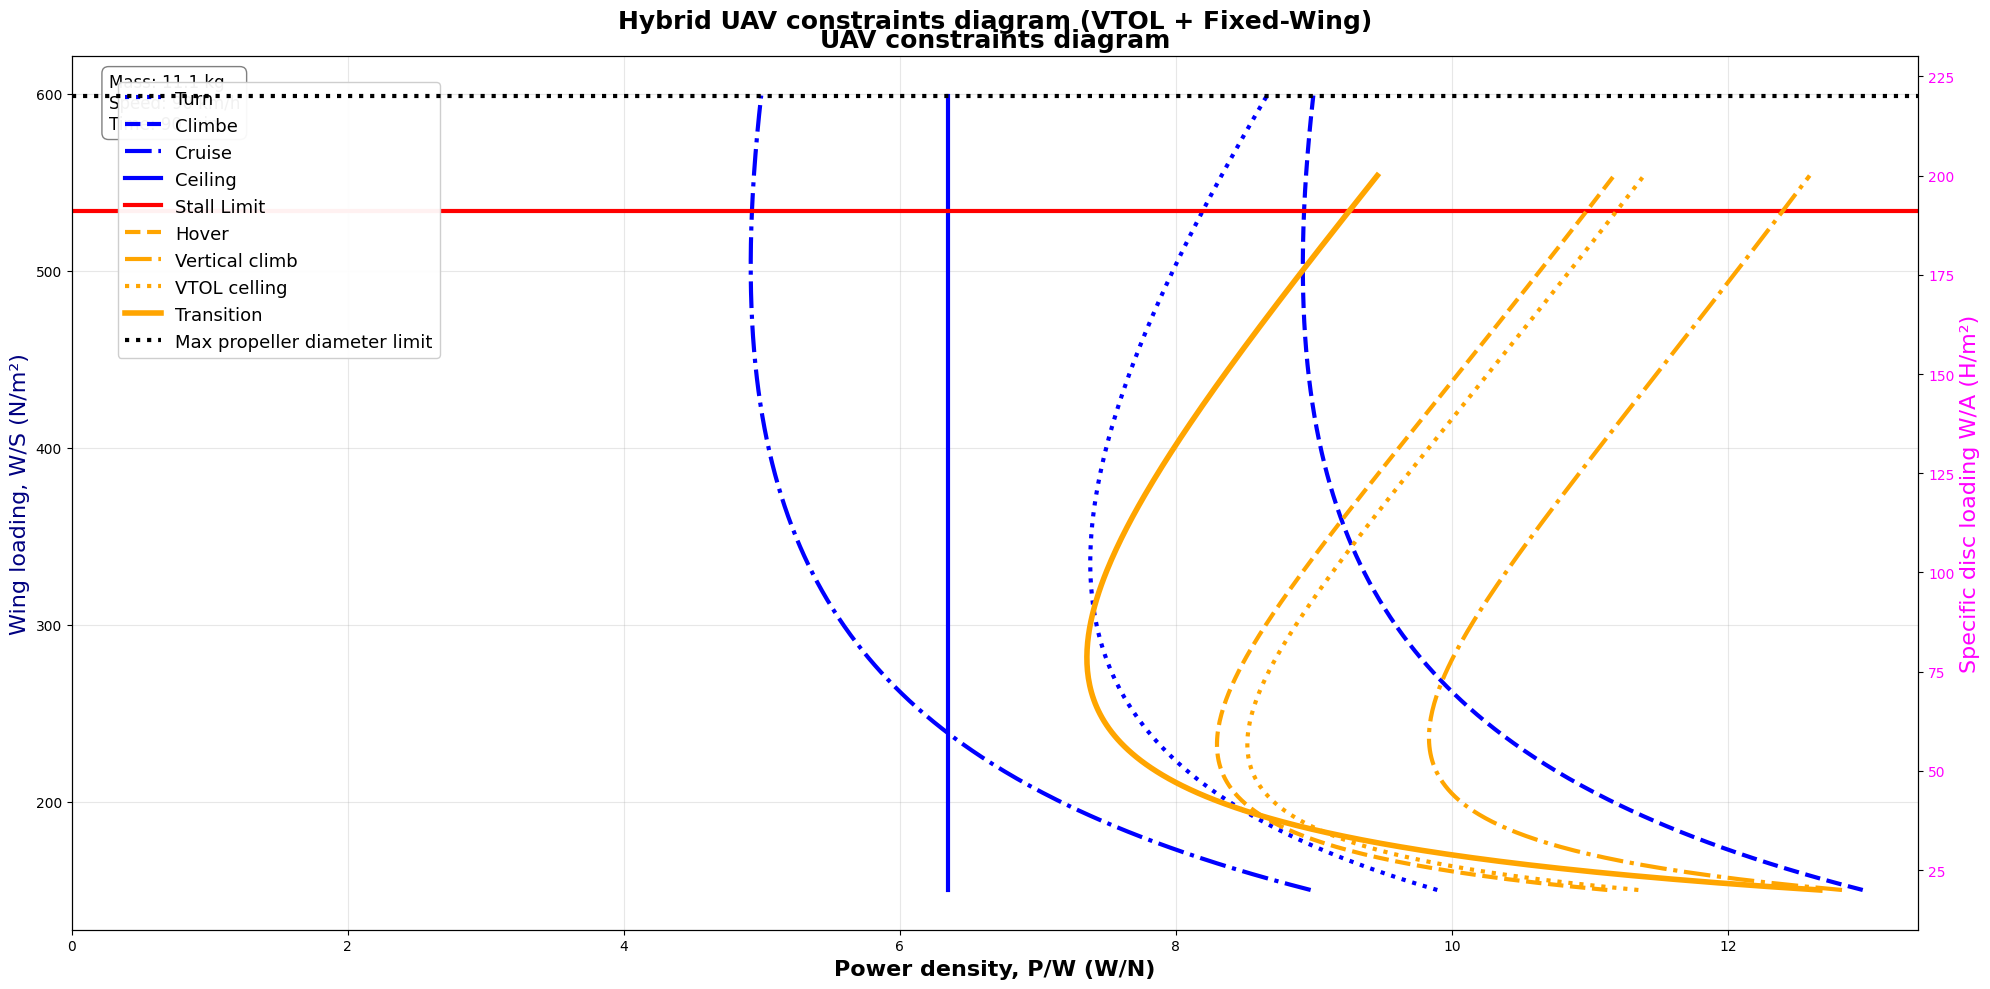

In [ ]:
# Take-off weight base on mass from second approximation
weight_takeoff = m0_final * g

# Speed on transition
Vinf = stall_speed_ms

# Angels
teta_tilt_90 = np.pi / 2
alpha_rotor_trans = 0
V_tip_transition_helical = np.sqrt(Vtip**2 + Vinf**2)
mu = Vinf * np.cos(alpha_rotor_trans) / V_tip_transition_helical

# Wing loading on stall
wing_loading_stall = max_lift_coefficient*(air_density_sea_level*stall_speed_ms**2)/prop_efficiency
print(wing_loading_stall)

# Range of applyable wing loading in N/m^2
wing_loading_range = np.arange(150, 600, 1, dtype=float)

# Initialize arrays for storing results as floats
power_loading_turn_P_W = np.zeros_like(wing_loading_range, dtype=float)
power_loading_cruise_P_W = np.zeros_like(wing_loading_range, dtype=float)
power_loading_climb_P_W = np.zeros_like(wing_loading_range, dtype=float)
power_loading_ceiling_P_W = np.zeros_like(wing_loading_range, dtype=float)

q = 0.5 * air_density_cruise * cruise_speed_ms**2
n_load = 1.5 # Overload on wing

disc_loading_max_diameter = weight_takeoff / total_disc_area_max

# Horizontal mode calculation
# Power loading on cruise speed and altitude 
def pw_cruise(wl): 
    return (cruise_speed_ms / prop_efficiency) * (q * zero_lift_drag_cruise / wl + induced_drag_factor_K * wl / q)

# Power loading on velcoity turn
def pw_turn(wl): 
    return (cruise_speed_ms / prop_efficiency) * (q * zero_lift_drag_cruise / wl + induced_drag_factor_K * n_load**2 * wl / q)

# Power loading on climb
def pw_climb(wl): 
    return (3.0 / prop_efficiency) + (cruise_speed_ms / prop_efficiency) * (q * zero_lift_drag_cruise / wl + induced_drag_factor_K * wl / q)

# Power loading on ceiling
def pw_ceiling(wl): 
    return (0.5 / prop_efficiency) + (cruise_speed_ms / prop_efficiency) * 4 * np.sqrt(induced_drag_factor_K * zero_lift_drag_cruise / 3)

# Inserting values into arrays
for i, wing_loading_dif in enumerate(wing_loading_range):
    power_loading_cruise_P_W[i] = pw_cruise(wing_loading_dif)
    power_loading_turn_P_W[i] = pw_turn(wing_loading_dif)
    power_loading_climb_P_W[i] = pw_climb(wing_loading_dif)
    power_loading_ceiling_P_W[i] = pw_ceiling(wing_loading_dif)

# Vertical mode calculation
# Power loading on hover
def pw_hover(disc_loading):
    A = weight_takeoff / disc_loading
    P_ind = induced_power_factor_hover * np.sqrt(weight_takeoff) / np.sqrt(2 * air_density_sea_level * A)
    P_prof = air_density_sea_level * A * Vtip**3 * solidity * Cd_blade / (8 * weight_takeoff)
    return P_ind + P_prof

# Power loading on climb
def pw_vertical_climb(disc_loading, Vy):
    term1 = Vy * (1 - induced_power_factor_climb / 2)
    term2 = (induced_power_factor_climb / 2) * np.sqrt(Vy**2 + 2 * disc_loading / air_density_sea_level)
    term3 = air_density_sea_level * Vtip**3 * solidity * Cd_blade / (8 * disc_loading)
    return term1 + term2 + term3

#Power loading on transition
def pw_transition(disc_loading):
    term1 = 1.2 / np.sin(teta_tilt_90) * np.sqrt(-Vinf**2 / 2 + np.sqrt((Vinf**2 / 2)**2 + (disc_loading / (2 * air_density_sea_level * np.sin(teta_tilt_90)))**2))
    term2 = (air_density_sea_level * V_tip_transition_helical**3 / disc_loading * (solidity * Cd_blade / 8 * (1 + 4.6 * mu**2)))
    term3 = (0.5 * air_density_sea_level * Vinf**3 * zero_lift_drag_cruise / wing_loading_optimum_airborne + 2 * induced_drag_factor_K * wing_loading_optimum_airborne / (air_density_sea_level * Vinf))
    return term1 + term2 + term3


disc_loading_range = np.linspace(20, 200, 200)  # Н/м²

# Inserting values for vertical mode into array
pw_hover_arr = np.array([pw_hover(dl) for dl in disc_loading_range])
pw_vclimb_arr = np.array([pw_vertical_climb(dl, Vy_climb) for dl in disc_loading_range])
pw_vceiling_arr = np.array([pw_vertical_climb(dl, Vy_ceiling) for dl in disc_loading_range])
pw_trans_arr = np.array([pw_transition(dl) for dl in disc_loading_range])

# Creating of diagram
fig, ax1 = plt.subplots(figsize=(20, 10))

# Левая ось: Wing Loading (W/S) vs P/W
ax1.plot(power_loading_turn_P_W, wing_loading_range, ':', color='blue', linewidth=3, label='Turn')
ax1.plot(power_loading_climb_P_W, wing_loading_range, '--', color='blue', linewidth=3, label='Climbe')
ax1.plot(power_loading_cruise_P_W, wing_loading_range, '-.', color='blue', linewidth=3, label='Cruise')
ax1.plot(power_loading_ceiling_P_W, wing_loading_range, '-', color='blue', linewidth=3, label='Ceiling')

ax1.axhline(y=wing_loading_stall, color='red', linewidth=3, label='Stall Limit')

ax1.set_xlabel('Power density, P/W (W/N)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Wing loading, W/S (N/m²)', fontsize=16, color='navy')
ax1.set_title('UAV constraints diagram', fontsize=18, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=0)  # Убираем отрицательные значения
# ax1.set_ylim(150, 600)

# ax1.legend(fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)

# plt.tight_layout()
# plt.show()

ax2 = ax1.twinx()

ax2.plot(pw_hover_arr, disc_loading_range, '--', color='orange', lw=3, label='Hover')
ax2.plot(pw_vclimb_arr, disc_loading_range, '-.', color='orange', lw=3, label='Vertical climb')
ax2.plot(pw_vceiling_arr, disc_loading_range, ':', color='orange', lw=3, label='VTOL celling')
ax2.plot(pw_trans_arr, disc_loading_range, '-', color='orange', lw=4, label='Transition')

# Геометрическое ограничение
ax2.axhline(y=disc_loading_max_diameter, color='black', linestyle=':', lw=3, label='Max propeller diameter limit')

ax2.set_ylabel('Specific disc loading W/A (Н/m²)', fontsize=16, color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')

# === ЛЕГЕНДА ===
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize=13, framealpha=0.95)

# === АННОТАЦИИ ===
ax1.text(0.02, 0.98, f"Mass: {m0_final:.1f} kg\nSpeed: {cruise_speed} km/h\nTime: {flight_time} min",
         transform=ax1.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="gray"))

plt.title('Hybrid UAV constraints diagram (VTOL + Fixed-Wing)', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Step 4: Wing profile
## Calculation of wing profile by characteristics and formulas

In [ ]:
phi = math.radians(90 / (number_point_on_chord - 1))
zero_lift_angel = -90 * profile_curv

# max_lift_coefficient - maximum lift coefficient by statistic for this UAV class
critical_attack_angel_profile = zero_lift_angel + profile_max_lift_coefficient / (2*np.pi) * 57.3 + 2
print(critical_attack_angel_profile)

# Functions for wing profile calculation
def phi_profile_angel(n):
    return phi * (n - 1)

def x_profile(n):
    return 1 - np.cos((n-1)*phi)

def ytx_profile(x):
    return 5 * profile_thickness * (0.2969 * x ** 0.5 - 0.126 * x - 0.3516 * x ** 2 + 0.2843 * x ** 3 - 0.1015 * x ** 4)

def ycx_profile(x):
    if x <= max_curv_point:
        res = profile_curv * (2 * max_curv_point - n) * n / (max_curv_point ** 2)
    else:
        res = profile_curv * ((1 - 2 * max_curv_point) + 2 * max_curv_point * x - x ** 2) / (1 - max_curv_point) ** 2
    return res

def yc1t_profile(x):
    if x <= max_curv_point:
        res = 2 * profile_curv / max_curv_point * (1 - x / max_curv_point)
    else:
        res = 2 * profile_curv * (max_curv_point - x) / (1 - max_curv_point) ** 2
    return res

def theta(y1):
    return np.arctan(y1)

def x_upper_profile(x, ytx, θ):
    return x - ytx * np.sin(θ)

def x_lower_profile(x, ytx, θ):
    return x + ytx * np.cos(θ)

def y_upper_profile(ycx, ytx, θ):
    return ycx + ytx  * np.cos(θ)

def y_lower_profile(ycx, ytx, θ):
    return ycx - ytx * np.cos(θ)

# Creating range for arrays
n_points = range(1, number_point_on_chord + 1)

# Creating and filling arrays
phi_profile_angel_arr = np.array([phi_profile_angel(n) for n in n_points])
x_profile_arr = np.array([x_profile(n) for n in n_points])
# ytx_profile_arr = np.array([ytx_profile(x_profile_arr[i]) for i in range(len(n_points))])
ytx_profile_arr = np.array([ytx_profile(x) for x in x_profile_arr])
ycx_profile_arr = np.array([ycx_profile(x) for x in x_profile_arr])
yc1t_profile_arr = np.array([yc1t_profile(x) for x in x_profile_arr])
theta_arr = np.array([theta(yc1t) for yc1t in yc1t_profile_arr])

x_upper_profile_arr = np.array([x_upper_profile(x_profile_arr[i], ytx_profile_arr[i], theta_arr[i]) for i in range(len(n_points))])
x_lower_profile_arr = np.array([x_lower_profile(x_profile_arr[i], ytx_profile_arr[i], theta_arr[i]) for i in range(len(n_points))])
y_upper_profile_arr = np.array([y_upper_profile(ycx_profile_arr[i], ytx_profile_arr[i], theta_arr[i]) for i in range(len(n_points))])
y_lower_profile_arr = np.array([y_lower_profile(ycx_profile_arr[i], ytx_profile_arr[i], theta_arr[i]) for i in range(len(n_points))])

data = {
    'n': n_points,
    'φ': phi_profile_angel_arr,
    'x': x_profile_arr,
    'yt(x)': ytx_profile_arr,
    'yc(x)': ycx_profile_arr,
    'yc\'(x)': yc1t_profile_arr,
    'θ': theta_arr,
    'x_upper': x_upper_profile_arr,
    'x_lower': x_lower_profile_arr,
    'y_upper': y_upper_profile_arr,
    'y_lower': y_lower_profile_arr
}

df = pd.DataFrame(data)

# Форматирование вывода
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Таблица параметров аэродинамического профиля:")
print("=" * 100)
print(df.round(6))
print("\n")

# Альтернативный вывод в стиле вашего файла
print("Форматированная таблица:")
print("n\tx\t\tyt(x)\t\tyc(x)\t\tyc'(x)\t\tθ\t\tx_upper\t\ty_upper\t\tx_lower\t\ty_lower")
print("-" * 120)
for i in range(len(n_points)):
    print(f"{n_points[i]}\t{x_profile_arr[i]:.6f}\t{ytx_profile_arr[i]:.6f}\t{ycx_profile_arr[i]:.6f}\t"
          f"{yc1t_profile_arr[i]:.6f}\t{theta_arr[i]:.6f}\t{x_upper_profile_arr[i]:.6f}\t"
          f"{y_upper_profile_arr[i]:.6f}\t{x_lower_profile_arr[i]:.6f}\t{y_lower_profile_arr[i]:.6f}")

12.535346270706686
Таблица параметров аэродинамического профиля:
     n         φ         x     yt(x)     yc(x)    yc'(x)         θ   x_upper  \
0    1  0.000000  0.000000  0.000000 -0.862500  0.200000  0.197396  0.000000   
1    2  0.054165  0.001467  0.006711 -0.862500  0.199267  0.196690  0.000155   
2    3  0.108331  0.005862  0.013189 -0.862500  0.197069  0.194576  0.003312   
3    4  0.162496  0.013173  0.019414 -0.862500  0.193413  0.191054  0.009487   
4    5  0.216662  0.023379  0.025358 -0.862500  0.188310  0.186131  0.018687   
5    6  0.270827  0.036450  0.030983 -0.862500  0.181775  0.179812  0.030909   
6    7  0.324992  0.052347  0.036246 -0.862500  0.173827  0.172107  0.046139   
7    8  0.379158  0.071023  0.041101 -0.862500  0.164488  0.163028  0.064352   
8    9  0.433323  0.092425  0.045498 -0.862500  0.153788  0.152592  0.085509   
9   10  0.487489  0.116488  0.049389 -0.862500  0.141756  0.140818  0.109556   
10  11  0.541654  0.143143  0.052728 -0.862500  0.12842

## Research of different wing profiles
For this research will be used Aerosandbox and NeuralFoil.
In this calculation, it is necessary to determine the values of symmetric and asymmetric profiles in order to compare one type with the other. The following  profiles are participating in this test:
- symmetric profiles:
    - NACA 0012
    - NACA 0015
    - HT-12
- asymmetrical profiles:
    - MH114
    - SD7062
    - RG15

NACA0012 calculated
NACA0015 calculated
HT-12 calculated
MH114 calculated
SD7062 calculated
RG15 calculated


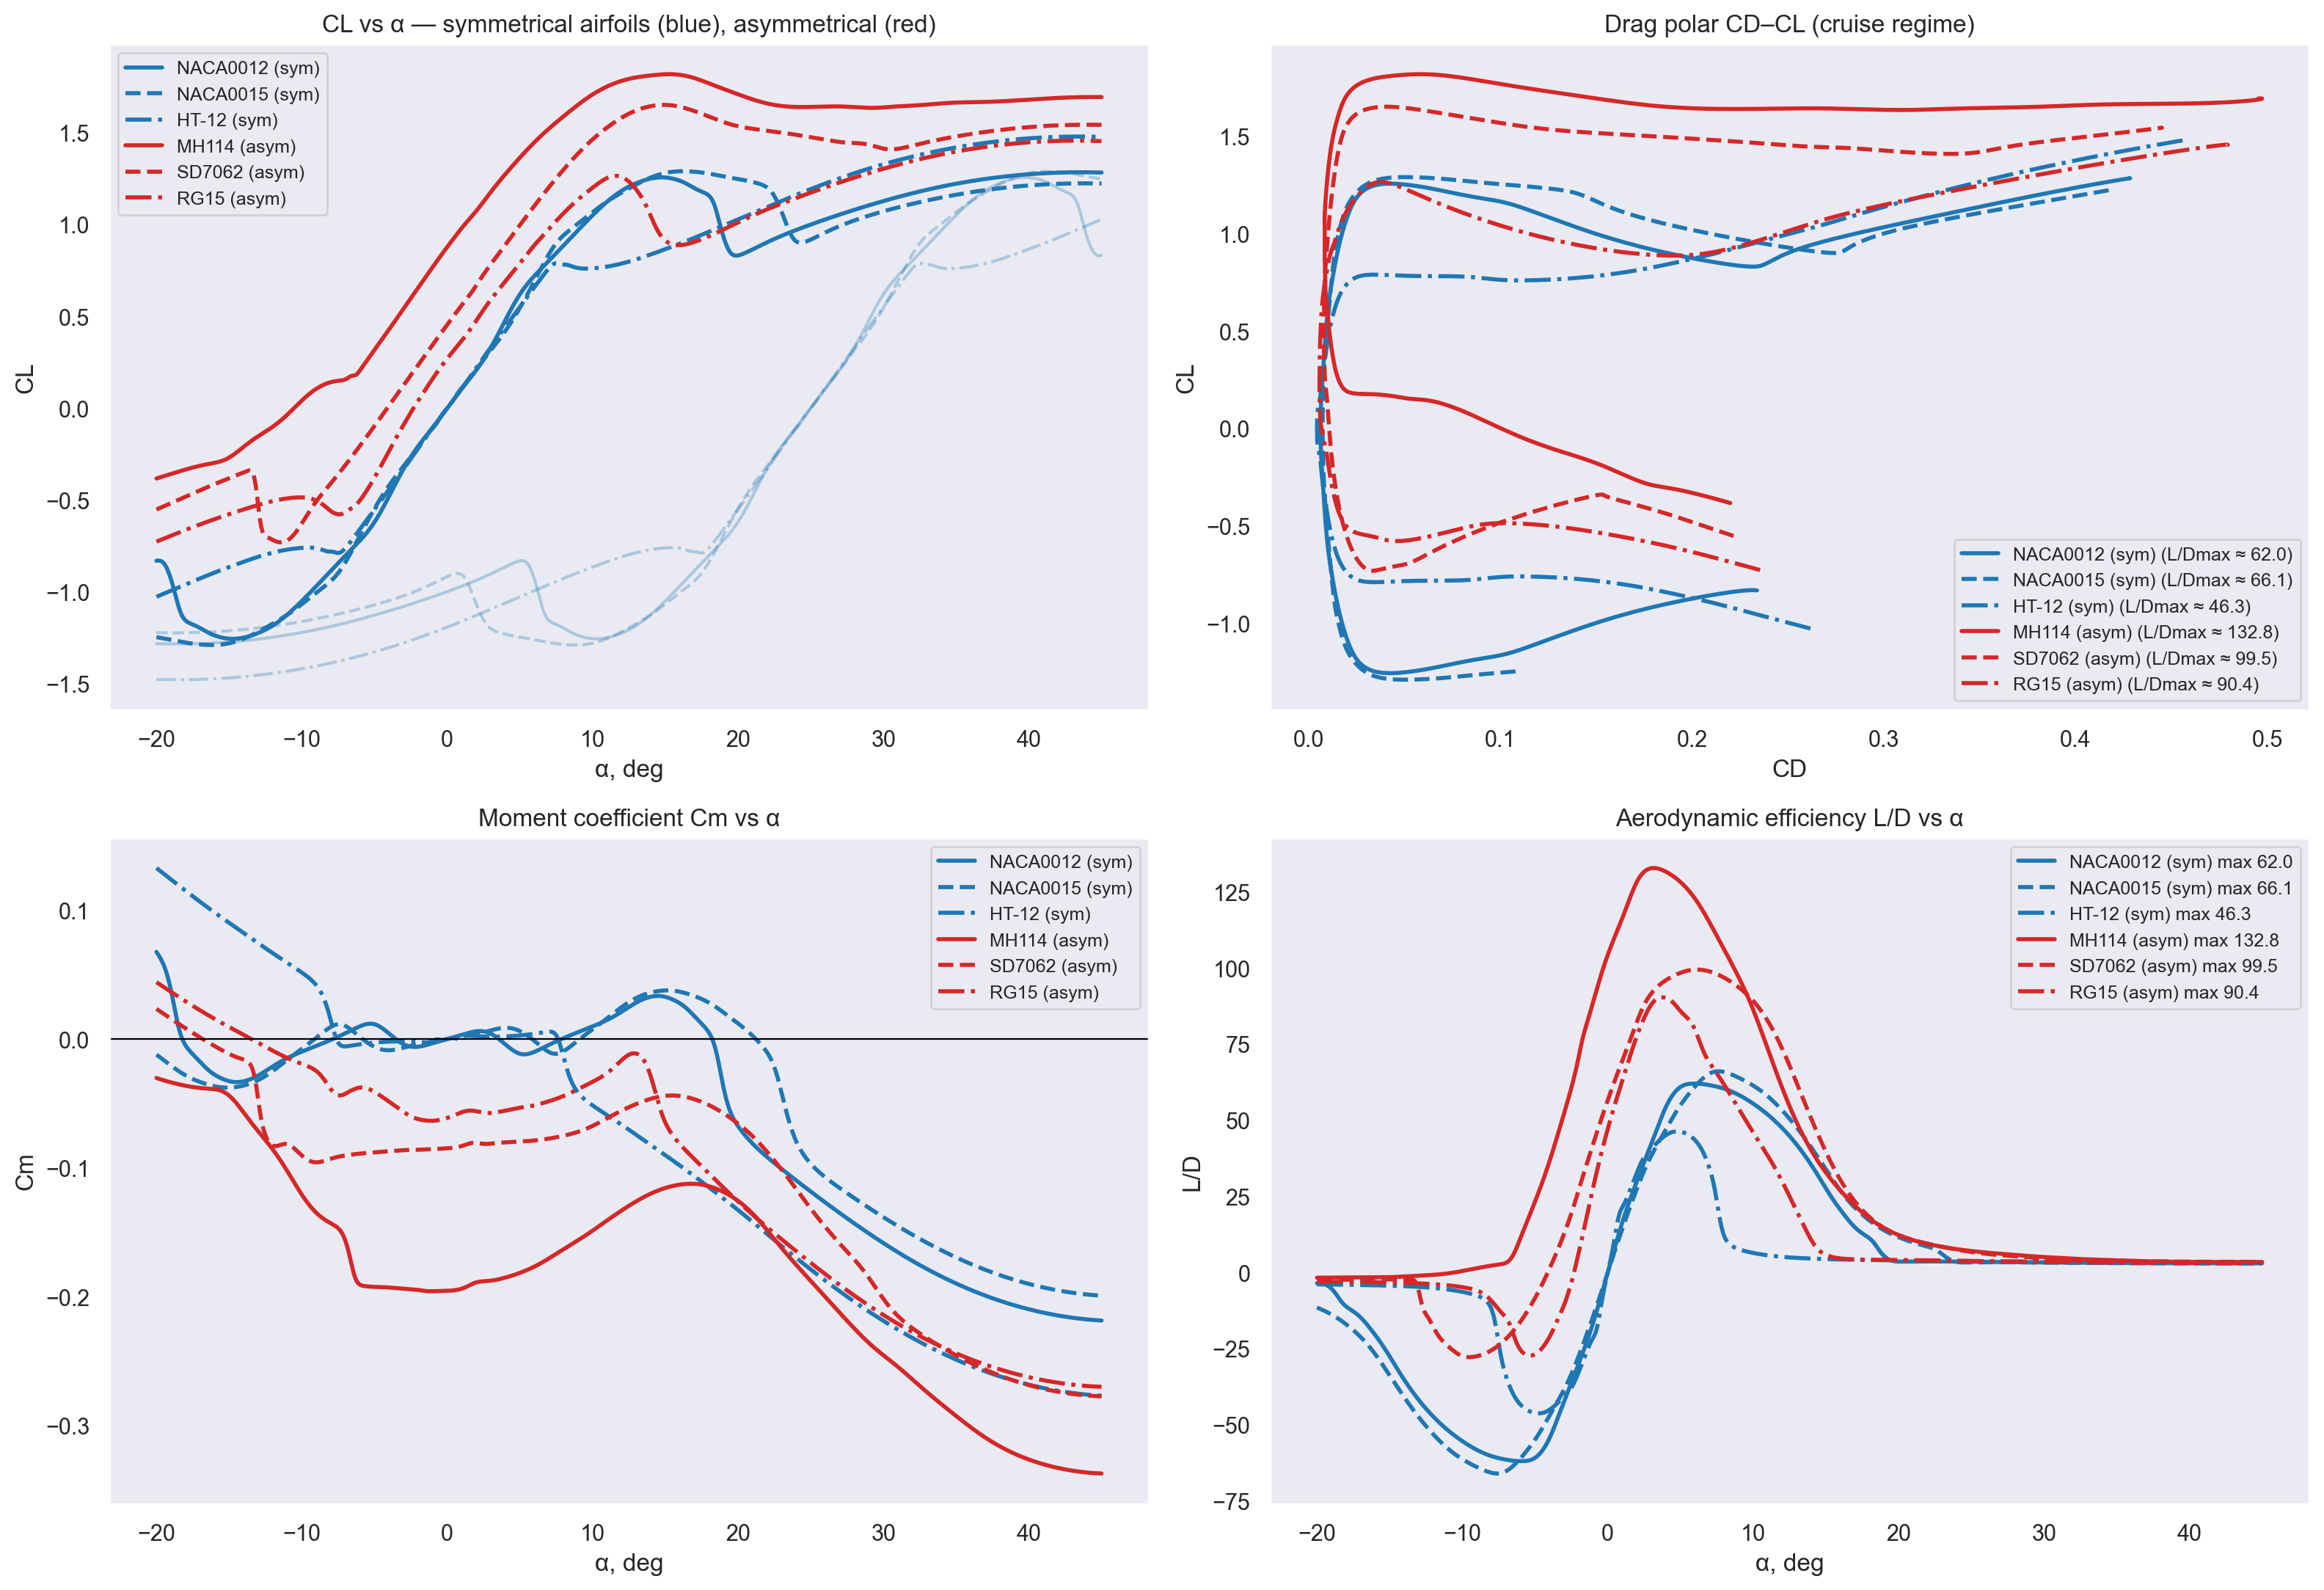

In [ ]:
# UAV parameters
alpha = np.linspace(-20, 45, 751)

# Airfoils: name → (code, type: sym / asym)
profiles = {
    "NACA0012": ("naca0012", "sym"),
    "NACA0015": ("naca0015", "sym"),
    "HT-12":    ("ht12",    "sym"),
    "MH114":    ("mh114",   "asym"),
    "SD7062":   ("sd7062",  "asym"),
    "RG15":     ("rg15",    "asym")
}

results = {}
for name, (code, ptype) in profiles.items():
    af = asb.Airfoil(code)
    aero = nf.get_aero_from_airfoil(
        airfoil=af,
        alpha=alpha,
        Re=Re_cruise,
        model_size="xxlarge"      # highest accuracy model
    )
    results[name] = (aero, ptype)
    print(f"{name} calculated")

# Line styles to distinguish airfoils within the same group
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 1))]

fig, axs = plt.subplots(2, 2, figsize=(16, 11))

sym_idx = 0   # counter for symmetrical airfoils
asym_idx = 0  # counter for asymmetrical airfoils

for name, (res, ptype) in results.items():
    if ptype == "sym":
        color = '#1f77b4'   # blue for symmetrical airfoils
        ls = line_styles[sym_idx % len(line_styles)]
        sym_idx += 1
    else:
        color = '#d62728'   # red for asymmetrical (cambered) airfoils
        ls = line_styles[asym_idx % len(line_styles)]
        asym_idx += 1

    label = f"{name} ({ptype})"

    # CL vs alpha
    axs[0,0].plot(alpha, res["CL"], label=label, color=color, linestyle=ls, linewidth=2)
    # mirrored curve (transparent) only for symmetrical airfoils – visual symmetry check
    if ptype == "sym":
        axs[0,0].plot(alpha, -res["CL"][::-1], color=color, linestyle=ls, alpha=0.3, linewidth=1.5)

    # Drag polar
    LD_max = (res["CL"] / res["CD"]).max()
    axs[0,1].plot(res["CD"], res["CL"],
                  label=f"{label} (L/Dmax ≈ {LD_max:.1f})",
                  color=color, linestyle=ls, linewidth=2)

    # Moment coefficient Cm vs alpha
    axs[1,0].plot(alpha, res["CM"], label=label, color=color, linestyle=ls, linewidth=2)

    # Glide ratio L/D vs alpha
    LD = res["CL"] / res["CD"]
    axs[1,1].plot(alpha, LD,
                  label=f"{label} max {LD.max():.1f}",
                  color=color, linestyle=ls, linewidth=2)

# Plot formatting (English annotations)
axs[0,0].set_title("CL vs α — symmetrical airfoils (blue), asymmetrical (red)")
axs[0,0].set_xlabel("α, deg"); axs[0,0].set_ylabel("CL"); axs[0,0].grid(); axs[0,0].legend(fontsize=9)

axs[0,1].set_title("Drag polar CD–CL (cruise regime)")
axs[0,1].set_xlabel("CD"); axs[0,1].set_ylabel("CL"); axs[0,1].grid(); axs[0,1].legend(fontsize=9)

axs[1,0].set_title("Moment coefficient Cm vs α")
axs[1,0].set_xlabel("α, deg"); axs[1,0].set_ylabel("Cm"); axs[1,0].grid()
axs[1,0].axhline(0, color='k', linewidth=0.8); axs[1,0].legend(fontsize=9)

axs[1,1].set_title("Aerodynamic efficiency L/D vs α")
axs[1,1].set_xlabel("α, deg"); axs[1,1].set_ylabel("L/D"); axs[1,1].grid(); axs[1,1].legend(fontsize=9)

plt.tight_layout()
plt.show()

According to the graphs obtained for certain symmetric and asymmetric profiles, the following consistent conclusions can be drawn:
- Symmetric profiles produce lower lift. By 0.2 CL at the same angle of attack within the range of angles from -10 to 10 degrees.
- The maximum lift values for symmetric profiles are lower by 0.4.
- Symmetric profiles have drag similar to that of asymmetric profiles.
- Symmetric profiles have a moment close to zero within the angle of attack range from -10 to 10 degrees. This parameter is very important for aircraft without horizontal stabilisers.

Next, the force required to counteract the force acting perpendicular to the chord of an asymmetric aerofoil from the oncoming airflow generated by the propeller is examined.

In [ ]:
profiles = ["mh114", "sd7062", "naca0012", "ht12"]
alpha_hover = np.array([0.0])  # обдув вдоль хорды

trust_takeoff = take_off_weight
V_slip = np.sqrt(trust_takeoff / (air_density_sea_level * total_disc_area_max))
q_slip = 0.5 * air_density_sea_level * V_slip**2

for name in profiles:
    af = asb.Airfoil(name)
    aero = nf.get_aero_from_airfoil(
        airfoil=af,
        alpha=alpha_hover,
        Re=Re_cruise,
        model_size="xxlarge"
    )
    CL = aero["CL"][0]
    CD = aero["CD"][0]
    Cm = aero["CM"][0]
    
    # Боковая сила от swirl (эмпирика Selig/Hoerner для axial flow с swirl)
    swirl_factor = 0.08  # ~8% от axial для типичного пропеллера (P-factor like)
    Cy_swirl = swirl_factor * af.max_camber() * 4  # грубо для камбера
    
    Fy = q_slip * S_wing * Cy_swirl  # Н
    Nz = Fy * 0.3  # плечо ~0.3 м
    
    print(f"{name.upper():8} | CL_slip {CL:.3f} | CD_slip {CD:.3f} | Fy_swirl ≈ {Fy:+5.1f} Н | Nz ≈ {Nz:+5.1f} Н·м")

MH114    | CL_slip 0.878 | CD_slip 0.008 | Fy_swirl ≈  +4.3 Н | Nz ≈  +1.3 Н·м
SD7062   | CL_slip 0.454 | CD_slip 0.008 | Fy_swirl ≈  +2.6 Н | Nz ≈  +0.8 Н·м
NACA0012 | CL_slip 0.000 | CD_slip 0.006 | Fy_swirl ≈  +0.0 Н | Nz ≈  +0.0 Н·м
HT12     | CL_slip 0.000 | CD_slip 0.004 | Fy_swirl ≈  +0.0 Н | Nz ≈  +0.0 Н·м


# Step 5: Wing characteristics

Calculation of unmanned aerial vehicle wing characteristics. Finding MAC.

Таблица поляры крыла:
 Коэффициент подъёмной силы  Коэффициент лобового сопротивления
              -8.000000e-01                            0.135664
              -7.900000e-01                            0.134946
              -7.800000e-01                            0.134237
              -7.700000e-01                            0.133537
              -7.600000e-01                            0.132846
              -7.500000e-01                            0.132164
              -7.400000e-01                            0.131491
              -7.300000e-01                            0.130827
              -7.200000e-01                            0.130172
              -7.100000e-01                            0.129526
              -7.000000e-01                            0.128890
              -6.900000e-01                            0.128262
              -6.800000e-01                            0.127643
              -6.700000e-01                            0.127033
              -6.6

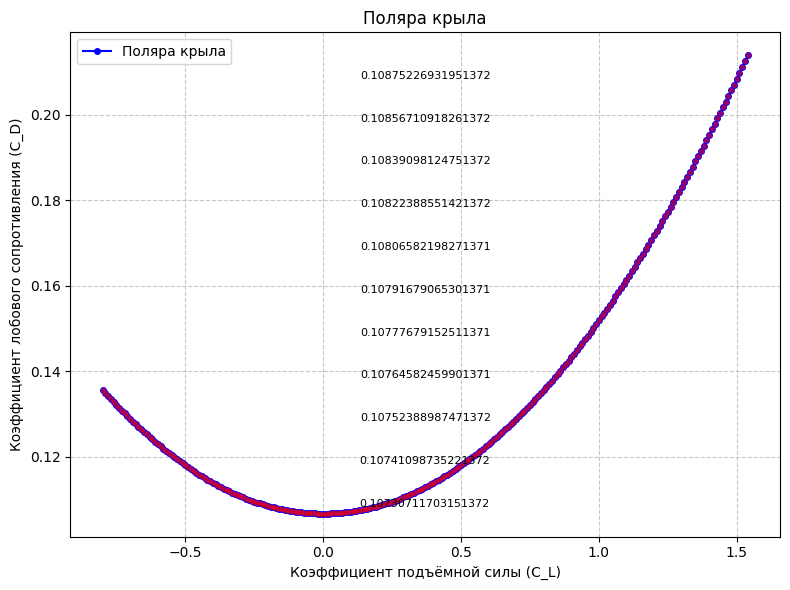

In [ ]:

root_sweep_angel = 90 - np.arctan(wingspan / (root_chord_lenght - tip_chord_lenght))
x_coor_root_MAC = wingspan / 6 * (2 * wing_narrowing + 1) / (wing_narrowing + 1)
y_coor_root_MAC = root_sweep_angel*np.arctan(x_coor_root_MAC)

zero_lift_angel_of_attack = zero_lift_angel + angel_of_incedence
kl = -0.0125 * (1 / wing_narrowing) ** 2 + 0.0675 * (1 / wing_narrowing) + 0.8475
max_lift_coefficient_wing = 0.5 * kl * (1 + np.cos(np.radians(wing_tip_twist))) * profile_max_lift_coefficient
derivative_lift_coefficient_wing = 2 * np.pi * AR * np.cos(np.radians(wing_tip_twist)) / (2 + AR)
critical_attack_angel_wing = zero_lift_angel_of_attack + max_lift_coefficient_wing / derivative_lift_coefficient_wing * 57.3

over_lift_angel = 1.15 * critical_attack_angel_wing
over_lift_coefficient_wing = (over_lift_angel + zero_lift_angel_of_attack) * derivative_lift_coefficient_wing / 57.3

# Plotting the wing polar graph

wing_lift_coefficient_array = np.arange(-0.8, max_lift_coefficient_wing + 0.1, 0.01)

def wing_drag_coefficient(CL):
    return zero_lift_drag_cruise + CL ** 2 * drag_coefficient_constant

wing_drag_coefficient_array = wing_drag_coefficient(wing_lift_coefficient_array)

data = {
    "Коэффициент подъёмной силы": wing_lift_coefficient_array,
    "Коэффициент лобового сопротивления": wing_drag_coefficient_array
}
df = pd.DataFrame(data)

# === ШАГ 7: Выводим таблицу ===
print("Таблица поляры крыла:")
print(df.to_string(index=False))

# === ШАГ 8: Строим график ===
plt.figure(figsize=(8, 6))
plt.plot(wing_lift_coefficient_array, wing_drag_coefficient_array, 'b-o', label='Поляра крыла', markersize=4)
plt.plot(wing_lift_coefficient_array, wing_drag_coefficient_array, 'ro', alpha=0.5, markersize=3)  # точки из таблицы

plt.ylabel('Коэффициент лобового сопротивления (C_D)')
plt.xlabel('Коэффициент подъёмной силы (C_L)')
plt.title('Поляра крыла')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Добавляем аннотации для ключевых точек (опционально)
for cl, cd in zip(wing_lift_coefficient_array, wing_drag_coefficient_array):
    if cl >= 0:  # только положительные C_L
        plt.annotate(f'{cd}', (cd, cl), textcoords="offset points", xytext=(5,-5), ha='left', fontsize=8)

plt.tight_layout()
plt.show()

# Vertical Stabilisator calculation

In [ ]:
vertical_static_stab_moment = 0.001 * wingspan + 0.03
vertical_shoulder_stab = -0.002 * wingspan + 0.3
vertical_relative_stab_area = vertical_static_stab_moment / vertical_shoulder_stab
vertical_stab_area = vertical_relative_stab_area * S_wing
vertical_stab_span = (vertical_stab_area * vertical_stab_aspect_ratio) ** (1/2)

# Распределение площади (можно менять по желанию)
fraction_side    = (1 - fraction_central) / 2   # по 30% на каждый боковой киль вниз

S_vt_central = vertical_stab_area * fraction_central
S_vt_side    = vertical_stab_area * fraction_side



central_area_check = (central_root_chord + central_tip_chord)/2 * central_span
scale_central = np.sqrt(S_vt_central / central_area_check)



side_area_check = (side_root_chord + side_tip_chord)/2 * side_span
scale_side = np.sqrt(S_vt_side / side_area_check)

# Drawing of UAV
In this section I will create and draw geometry of UAV  

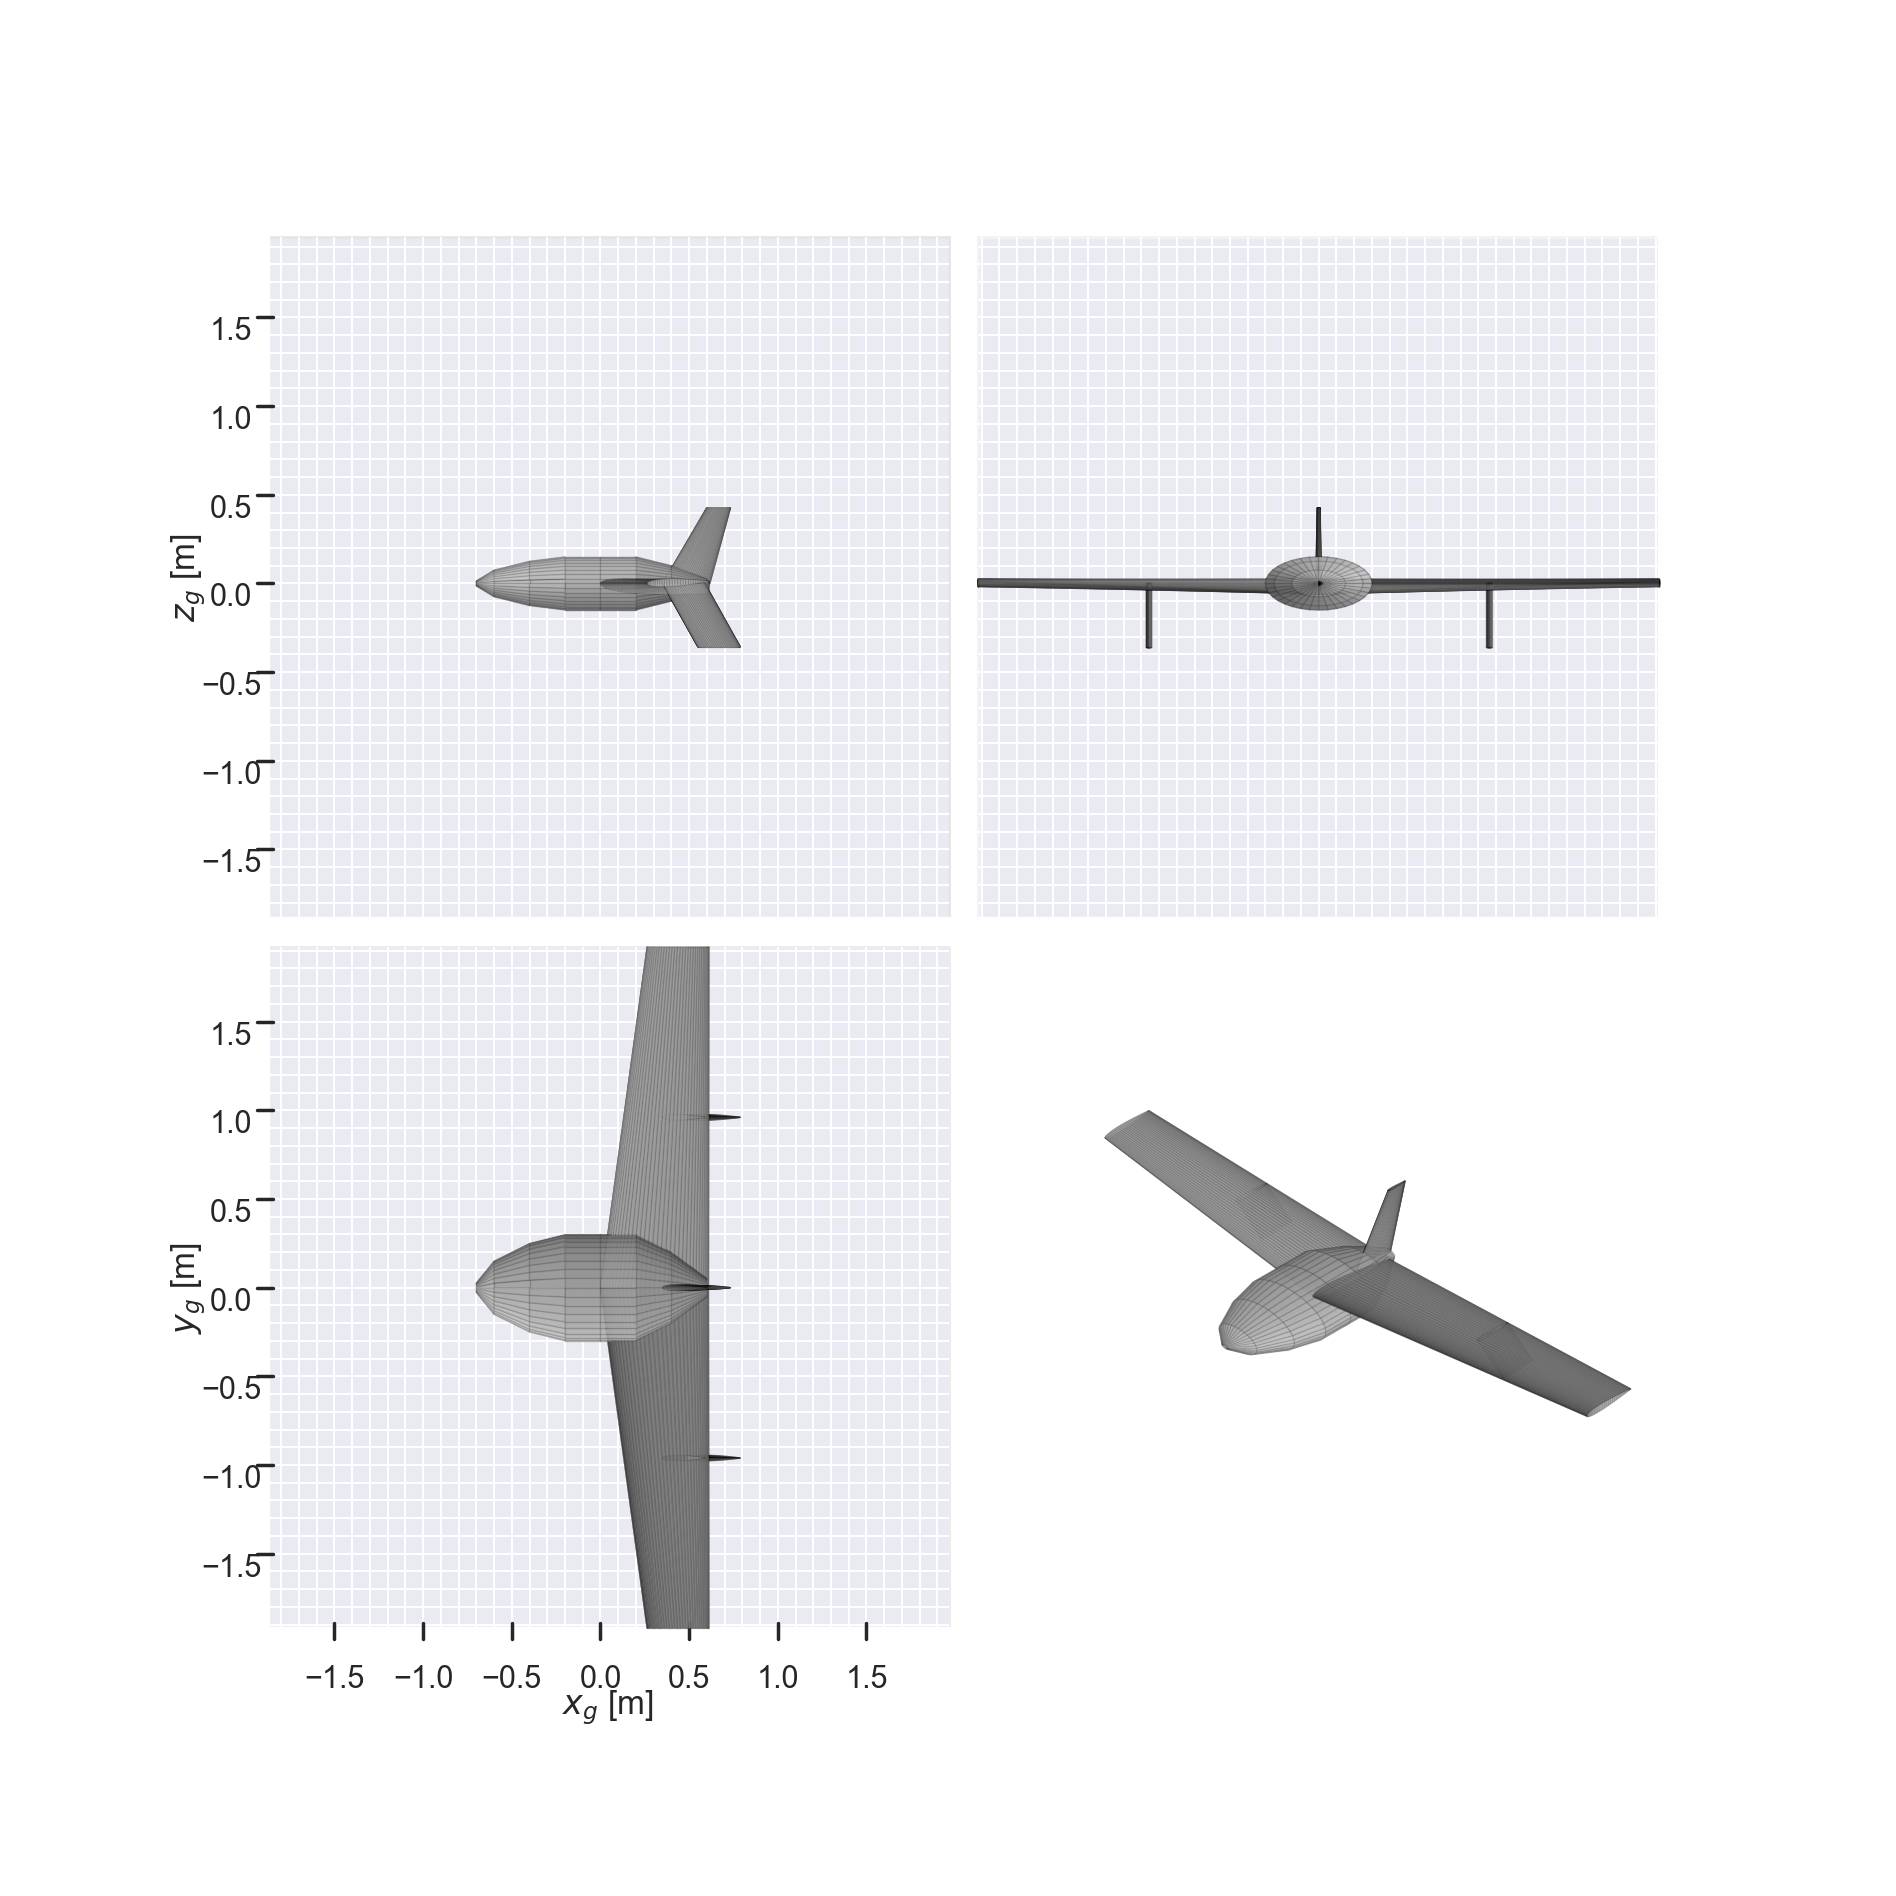

array([[<Axes3D: zlabel='$z_g$ [m]'>, <Axes3D: >],
       [<Axes3D: xlabel='$x_g$ [m]', ylabel='$y_g$ [m]'>, <Axes3D: >]],
      dtype=object)

In [ ]:
airplane = asb.Airplane(
    name="Flying Wing UAV with Triple Fins",
    xyz_ref=[root_chord_lenght * 0.25, 0, 0],
    s_ref=S_wing,
    c_ref=MAC,
    b_ref=AR,
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,
            xsecs=[
                # Корневая секция
                asb.WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=root_chord_lenght,
                    twist=5,
                    airfoil=asb.Airfoil("naca0012"),
                    control_surface_is_symmetric=False,
                    control_surface_deflection=0,
                ),
                # Концевая секция
                asb.WingXSec(
                    xyz_le=[root_chord_lenght - tip_chord_lenght, wingspan/2, 0],
                    chord=tip_chord_lenght,
                    twist=-2,
                    airfoil=asb.Airfoil("naca0012"),
                ),
            ],
        ),
        # Центральный вертикальный стабилизатор (вверх)
        asb.Wing(
            name="Central Fin Up",
            symmetric=False,
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0.35, 0, 0],  # Начинается от фюзеляжа
                    chord=central_root_chord * scale_central,
                    twist=0,
                    airfoil=asb.Airfoil("naca0012"),
                ),
                asb.WingXSec(
                    xyz_le=[0.35 + 0.25, 0, central_span * scale_central],  # Направлен вверх
                    chord=central_tip_chord * scale_central,
                    twist=0,
                    airfoil=asb.Airfoil("naca0012"),
                ),
            ],
        ),
        # Левый вертикальный стабилизатор (вниз)
        asb.Wing(
            name="Left Fin Down",
            symmetric=False,
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0.35, wingspan/4, 0],  # По центру левой консоли
                    chord=side_root_chord * scale_side,
                    twist=0,
                    airfoil=asb.Airfoil("naca0012"),
                ),
                asb.WingXSec(
                    xyz_le=[0.35 + 0.20, wingspan/4, -side_span * scale_side],  # Направлен вниз
                    chord=side_root_chord * scale_side,
                    twist=0,
                    airfoil=asb.Airfoil("naca0012"),
                ),
            ],
        ),
        # Правый вертикальный стабилизатор (вниз)
        asb.Wing(
            name="Right Fin Down",
            symmetric=False,
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0.35, -wingspan/4, 0],  # По центру правой консоли
                    chord=side_root_chord * scale_side,
                    twist=0,
                    airfoil=asb.Airfoil("naca0012"),
                ),
                asb.WingXSec(
                    xyz_le=[0.35 + 0.20, -wingspan/4, -side_span * scale_side],  # Направлен вниз
                    chord=side_root_chord * scale_side,
                    twist=0,
                    airfoil=asb.Airfoil("naca0012"),
                ),
            ],
        ),
    ],
    fuselages=[
        asb.Fuselage(
            name="Oval Body with Nose Cone",
            xsecs=[
                # Носовая часть - начинается с нулевого сечения и плавно увеличивается
                asb.FuselageXSec(
                    xyz_c=[-0.7, 0, 0],  # Носовая точка (x = -0.3)
                    width=0.05,  # Очень маленькое сечение в носу
                    height=0.025,
                ),
                # Плавное увеличение к основной части фюзеляжа
                asb.FuselageXSec(
                    xyz_c=[-0.6, 0, 0],
                    width=0.3,
                    height=0.15,
                ),
                asb.FuselageXSec(
                    xyz_c=[-0.4, 0, 0],  # Начало крыла
                    width=0.5,
                    height=0.25,
                ),
                # Основная цилиндрическая часть
                asb.FuselageXSec(
                    xyz_c=[-0.2, 0, 0],
                    width=0.6,
                    height=0.3,
                ),
                asb.FuselageXSec(
                    xyz_c=[0.0, 0, 0],
                    width=0.6,
                    height=0.3,
                ),
                asb.FuselageXSec(
                    xyz_c=[0.2, 0, 0],
                    width=0.6,
                    height=0.3,
                ),
                # Хвостовая часть - плавное сужение
                asb.FuselageXSec(
                    xyz_c=[0.4, 0, 0],
                    width=0.4,
                    height=0.2,
                ),
                asb.FuselageXSec(
                    xyz_c=[0.6, 0, 0],  # Конечная точка фюзеляжа (x = 1.0)
                    width=0.1,
                    height=0.05,
                ),
            ],
        )
    ],
)

airplane.draw_three_view()

# Refactored Calculation Functions
All calculations are now organized into reusable functions grouped by functional area.

In [ ]:
## 1. Mass and Power Calculations



def iterate_takeoff_mass(const, tol=0.5, max_iter=50):
    """
    Iteratively converge takeoff mass until tolerance is met.
    Returns dict with final values and iteration history.
    """
    m0 = calculate_zero_approximation_mass(const.payload_mass)
    g = 9.81
    history = []

    for i in range(max_iter):
        W0 = m0 * g
        V_cruise = const.cruise_speed / 3.6

        # Required cruise power
        P_req = W0 * V_cruise / (const.LD_ratio_cruise * const.prop_efficiency)
        P_per_motor = P_req / const.eng_q

        # Motor mass (statistical, 6S)
        U_pack = 6 * 4.2
        m_motor_one = 0.889 * (P_per_motor ** -0.288) * (U_pack ** 0.1588)

        # Propeller mass
        m_prop_one = const.k * (const.prop_D ** const.n) / 1000.0

        # Powerplant total
        m_powerplant = const.eng_q * (m_motor_one + m_prop_one) + const.prop_fasteners * const.eng_q

        # Battery
        E_req_wh = P_req * const.flight_time_hr
        m_battery = (E_req_wh / const.battery_specific_energy) * const.battery_mass_reserve

        # Structure & equipment
        m_structure = const.k_structure * m0
        m_eq = 0.3  # equipment fixed mass

        # New mass estimate
        m0_new = (const.payload_mass + m_structure + m_eq + m_powerplant + m_battery)
        m0_new *= const.takeoff_mass_reserve

        error = abs(m0_new - m0) / m0_new * 100.0
        history.append({
            "iter": i+1, "m0_kg": round(m0, 4), "m0_new_kg": round(m0_new, 4),
            "error_%": round(error, 3), "P_req_W": round(P_req, 1),
            "m_battery_kg": round(m_battery, 4), "m_powerplant_kg": round(m_powerplant, 4)
        })

        if error < tol:
            print(f"✓ Mass convergence in {i+1} iterations (Δ < {tol} %)")
            break

        m0 = m0_new

    result = {
        "final_m0_kg": m0_new,
        "m_battery_kg": m_battery,
        "m_powerplant_kg": m_powerplant,
        "P_req_W": P_req,
        "history": pd.DataFrame(history)
    }
    return result

def print_mass_summary(mass_result, const):
    """Print summary of mass iteration."""
    print(f"\n{'='*60}")
    print(f"MASS CONVERGENCE SUMMARY")
    print(f"{'='*60}")
    print(f"Final takeoff mass: {mass_result['final_m0_kg']:.3f} kg")
    print(f"Battery mass: {mass_result['m_battery_kg']:.3f} kg")
    print(f"Powerplant mass: {mass_result['m_powerplant_kg']:.3f} kg")
    print(f"Required power: {mass_result['P_req_W']:.1f} W")
    print(f"{'='*60}\n")

In [ ]:
## 2. Wing and Aerodynamic Parameters

def calculate_wing_loading_params(const):
    """Calculate wing loading at stall condition."""
    stall_speed_ms = const.stall_speed / 3.6
    dynamic_pressure = 0.5 * const.air_density_sea_level * stall_speed_ms ** 2
    wing_loading = const.max_lift_coefficient_stat * dynamic_pressure
    return {
        "stall_speed_ms": stall_speed_ms,
        "dynamic_pressure": dynamic_pressure,
        "wing_loading": wing_loading
    }

def calculate_wing_geometry(m0_final, wing_loading, const):
    """Calculate wing area, span, and chord dimensions."""
    g = 9.81
    take_off_weight = m0_final * g
    S_wing = take_off_weight / wing_loading
    wingspan = np.sqrt(const.AR * S_wing)
    root_chord = (2 * S_wing) / (wingspan * (1 + const.taper_ratio))
    tip_chord = const.taper_ratio * root_chord
    MAC = (2/3) * root_chord * (1 + const.taper_ratio + const.taper_ratio ** 2) / (1 + const.taper_ratio)
    
    return {
        "S_wing": S_wing,
        "wingspan": wingspan,
        "root_chord": root_chord,
        "tip_chord": tip_chord,
        "MAC": MAC
    }

def calculate_cruise_aerodynamics(const, wing_geo):
    """Calculate cruise aerodynamic parameters."""
    fric_coef = 0.74 / (const.Re_cruise ** 0.2)
    zero_lift_drag = const.SwetS * fric_coef
    induced_drag_factor_K = 0.3183 / const.AR / const.e
    
    dynamic_pressure_cruise = 0.5 * const.air_density_cruise * const.cruise_speed_ms ** 2
    wing_loading = wing_geo["S_wing"] * const.g / (const.payload_mass * const.g)  # rough estimate
    
    CL_opt = np.sqrt(zero_lift_drag / induced_drag_factor_K)
    CD_opt = zero_lift_drag + induced_drag_factor_K * CL_opt ** 2
    aerodynamic_quality = CL_opt / CD_opt
    
    return {
        "zero_lift_drag": zero_lift_drag,
        "induced_drag_factor_K": induced_drag_factor_K,
        "dynamic_pressure_cruise": dynamic_pressure_cruise,
        "CL_opt": CL_opt,
        "CD_opt": CD_opt,
        "aerodynamic_quality": aerodynamic_quality
    }

In [ ]:
## 3. Battery Parameters

def calculate_battery_params(const, m_battery):
    """Calculate battery pack parameters from cell specifications."""
    battery_weight = m_battery * const.g
    
    cell_total = const.series_cells_n * const.parallel_cells_n
    pack_cell_U_min = const.series_cells_n * const.cell_U_min
    pack_cell_U_max = const.series_cells_n * const.cell_U_max
    pack_cell_U = const.series_cells_n * const.cell_U
    pack_cell_capacity_A = const.parallel_cells_n * const.cell_capacity_nom_A
    pack_cell_capacity_W = const.parallel_cells_n * const.cell_capacity_nom_W
    pack_max_current = const.parallel_cells_n * const.max_current_cell
    pack_cell_mass = cell_total * const.cell_mass * const.battery_mass_coef
    
    total_battery_mass = pack_cell_mass
    total_battery_capacity = total_battery_mass / const.battery_mass_coef / const.cell_mass * const.parallel_cells_n
    
    return {
        "cell_total": cell_total,
        "pack_U_min": pack_cell_U_min,
        "pack_U_max": pack_cell_U_max,
        "pack_U": pack_cell_U,
        "pack_capacity_Ah": pack_cell_capacity_A,
        "pack_capacity_Wh": pack_cell_capacity_W,
        "pack_max_current": pack_max_current,
        "pack_mass": total_battery_mass,
        "battery_weight": battery_weight
    }

def print_battery_summary(battery_params):
    """Print battery parameters summary."""
    print(f"\n{'='*60}")
    print(f"BATTERY PACK SUMMARY")
    print(f"{'='*60}")
    print(f"Total cells: {battery_params['cell_total']}")
    print(f"Pack voltage: {battery_params['pack_U']:.1f} V (range: {battery_params['pack_U_min']:.1f}-{battery_params['pack_U_max']:.1f} V)")
    print(f"Pack capacity: {battery_params['pack_capacity_Ah']:.1f} Ah / {battery_params['pack_capacity_Wh']:.1f} Wh")
    print(f"Max current: {battery_params['pack_max_current']:.1f} A")
    print(f"Pack mass: {battery_params['pack_mass']:.3f} kg")
    print(f"{'='*60}\n")

In [ ]:
## 4. Wing Profile Calculations

def calculate_airfoil_coordinates(const):
    """Generate NACA-like airfoil coordinates using analytical formulas."""
    phi = math.radians(90 / (const.number_point_on_chord - 1))
    
    n_points = range(1, const.number_point_on_chord + 1)
    
    def x_coord(n):
        return 1 - np.cos((n-1) * phi)
    
    def yt_coord(x):
        return 5 * const.profile_thickness * (0.2969 * x ** 0.5 - 0.126 * x - 0.3516 * x ** 2 + 0.2843 * x ** 3 - 0.1015 * x ** 4)
    
    def yc_coord(x):
        if x <= const.max_curv_point:
            return const.profile_curv * (2 * const.max_curv_point * x - x ** 2) / (const.max_curv_point ** 2)
        else:
            return const.profile_curv * ((1 - 2 * const.max_curv_point) + 2 * const.max_curv_point * x - x ** 2) / ((1 - const.max_curv_point) ** 2)
    
    def dyc_dx(x):
        if x <= const.max_curv_point:
            return 2 * const.profile_curv / const.max_curv_point * (1 - x / const.max_curv_point)
        else:
            return 2 * const.profile_curv * (const.max_curv_point - x) / ((1 - const.max_curv_point) ** 2)
    
    x_arr = np.array([x_coord(n) for n in n_points])
    yt_arr = np.array([yt_coord(x) for x in x_arr])
    yc_arr = np.array([yc_coord(x) for x in x_arr])
    dyc_arr = np.array([dyc_dx(x) for x in x_arr])
    theta_arr = np.array([np.arctan(dy) for dy in dyc_arr])
    
    x_upper = x_arr - yt_arr * np.sin(theta_arr)
    x_lower = x_arr + yt_arr * np.sin(theta_arr)
    y_upper = yc_arr + yt_arr * np.cos(theta_arr)
    y_lower = yc_arr - yt_arr * np.cos(theta_arr)
    
    profile_data = pd.DataFrame({
        'n': list(n_points),
        'x': x_arr,
        'yt': yt_arr,
        'yc': yc_arr,
        'dyc_dx': dyc_arr,
        'theta': theta_arr,
        'x_upper': x_upper,
        'y_upper': y_upper,
        'x_lower': x_lower,
        'y_lower': y_lower
    })
    
    return profile_data

def plot_airfoil_profile(profile_data):
    """Plot airfoil upper and lower surfaces."""
    plt.figure(figsize=(10, 4))
    plt.plot(profile_data['x_upper'], profile_data['y_upper'], 'b-', linewidth=2, label='Upper surface')
    plt.plot(profile_data['x_lower'], profile_data['y_lower'], 'r-', linewidth=2, label='Lower surface')
    plt.fill_between(profile_data['x_upper'], profile_data['y_upper'], profile_data['y_lower'], alpha=0.2)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Chord position')
    plt.ylabel('Thickness')
    plt.title('Wing Profile (NACA-like)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
## 5. Wing Characteristics and Polar

def calculate_wing_characteristics(const, wing_geo):
    """Calculate wing lift and drag characteristics."""
    zero_lift_angle = -90 * const.profile_curv
    critical_angle_profile = zero_lift_angle + const.profile_max_lift_coefficient / (2 * np.pi) * 57.3 + 2
    
    zero_lift_angle_wing = zero_lift_angle + const.angel_of_incedence
    kl = -0.0125 * (1 / const.taper_ratio) ** 2 + 0.0675 * (1 / const.taper_ratio) + 0.8475
    max_lift_coeff_wing = 0.5 * kl * (1 + np.cos(np.radians(const.wing_tip_twist))) * const.profile_max_lift_coefficient
    derivative_lift_coeff = 2 * np.pi * const.AR * np.cos(np.radians(const.wing_tip_twist)) / (2 + const.AR)
    critical_angle_wing = zero_lift_angle_wing + max_lift_coeff_wing / derivative_lift_coeff * 57.3
    
    return {
        "zero_lift_angle": zero_lift_angle_wing,
        "max_lift_coeff": max_lift_coeff_wing,
        "derivative_lift_coeff": derivative_lift_coeff,
        "critical_angle": critical_angle_wing
    }

def calculate_wing_polar(const, wing_chars):
    """Generate wing lift and drag coefficients across angle of attack range."""
    CL_array = np.arange(-0.8, wing_chars["max_lift_coeff"] + 0.1, 0.01)
    CD_array = const.drag_coefficient_constant + (CL_array ** 2) * const.drag_coefficient_constant
    
    polar_data = pd.DataFrame({
        "CL": CL_array,
        "CD": CD_array,
        "L/D": CL_array / CD_array
    })
    
    return polar_data

def plot_wing_polar(polar_data):
    """Plot wing lift-drag polar."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Drag polar
    ax1.plot(polar_data['CD'], polar_data['CL'], 'b-', linewidth=2)
    ax1.set_xlabel('Drag Coefficient (CD)')
    ax1.set_ylabel('Lift Coefficient (CL)')
    ax1.set_title('Wing Drag Polar')
    ax1.grid(True, alpha=0.3)
    
    # L/D efficiency
    valid_idx = polar_data['CL'] > 0
    ax2.plot(polar_data.loc[valid_idx, 'CL'], polar_data.loc[valid_idx, 'L/D'], 'r-', linewidth=2)
    max_ld = polar_data.loc[valid_idx, 'L/D'].max()
    ax2.axhline(max_ld, color='r', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Lift Coefficient (CL)')
    ax2.set_ylabel('L/D Ratio')
    ax2.set_title(f'Wing Efficiency (max L/D ≈ {max_ld:.1f})')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
## 6. Constraint Diagram (Hybrid VTOL+Fixed Wing)

def calculate_constraint_diagram(const, m0_final, wing_geo, aero_params):
    """Calculate all power and disc loading constraints for the constraint diagram."""
    g = 9.81
    weight_takeoff = m0_final * g
    
    disc_loading_max = weight_takeoff / const.total_disc_area_max
    wing_loading_stall = const.max_lift_coefficient * (const.air_density_sea_level * (const.stall_speed / 3.6) ** 2) / const.prop_efficiency
    
    wing_loading_range = np.arange(150, 600, 1, dtype=float)
    disc_loading_range = np.linspace(20, 200, 200)
    
    # Fixed-wing mode constraints (horizontal flight)
    q = 0.5 * const.air_density_cruise * const.cruise_speed_ms ** 2
    n_load = 1.5
    
    def pw_cruise(wl):
        return (const.cruise_speed_ms / const.prop_efficiency) * (q * aero_params["zero_lift_drag"] / wl + 
                                                                   aero_params["induced_drag_factor_K"] * wl / q)
    
    def pw_turn(wl):
        return (const.cruise_speed_ms / const.prop_efficiency) * (q * aero_params["zero_lift_drag"] / wl + 
                                                                   aero_params["induced_drag_factor_K"] * n_load ** 2 * wl / q)
    
    def pw_climb(wl):
        return (const.climbe_rate / const.prop_efficiency) + (const.cruise_speed_ms / const.prop_efficiency) * \
               (q * aero_params["zero_lift_drag"] / wl + aero_params["induced_drag_factor_K"] * wl / q)
    
    def pw_ceiling(wl):
        return (const.ceiling_rate_of_climb / const.prop_efficiency) + (const.cruise_speed_ms / const.prop_efficiency) * \
               4 * np.sqrt(aero_params["induced_drag_factor_K"] * aero_params["zero_lift_drag"] / 3)
    
    # VTOL mode constraints
    def pw_hover(dl):
        A = weight_takeoff / dl
        P_ind = const.induced_power_factor_hover * np.sqrt(weight_takeoff) / np.sqrt(2 * const.air_density_sea_level * A)
        P_prof = const.air_density_sea_level * A * const.Vtip ** 3 * const.solidity * const.Cd_blade / (8 * weight_takeoff)
        return P_ind + P_prof
    
    def pw_vertical_climb(dl, Vy):
        term1 = Vy * (1 - const.induced_power_factor_climb / 2)
        term2 = (const.induced_power_factor_climb / 2) * np.sqrt(Vy ** 2 + 2 * dl / const.air_density_sea_level)
        term3 = const.air_density_sea_level * const.Vtip ** 3 * const.solidity * const.Cd_blade / (8 * dl)
        return term1 + term2 + term3
    
    # Compute constraint arrays
    pw_cruise_arr = np.array([pw_cruise(wl) for wl in wing_loading_range])
    pw_turn_arr = np.array([pw_turn(wl) for wl in wing_loading_range])
    pw_climb_arr = np.array([pw_climb(wl) for wl in wing_loading_range])
    pw_ceiling_arr = np.array([pw_ceiling(wl) for wl in wing_loading_range])
    
    pw_hover_arr = np.array([pw_hover(dl) for dl in disc_loading_range])
    pw_vclimb_arr = np.array([pw_vertical_climb(dl, const.Vy_climb) for dl in disc_loading_range])
    pw_vceiling_arr = np.array([pw_vertical_climb(dl, const.Vy_ceiling) for dl in disc_loading_range])
    
    return {
        "wing_loading_range": wing_loading_range,
        "disc_loading_range": disc_loading_range,
        "pw_cruise": pw_cruise_arr,
        "pw_turn": pw_turn_arr,
        "pw_climb": pw_climb_arr,
        "pw_ceiling": pw_ceiling_arr,
        "pw_hover": pw_hover_arr,
        "pw_vclimb": pw_vclimb_arr,
        "pw_vceiling": pw_vceiling_arr,
        "wing_loading_stall": wing_loading_stall,
        "disc_loading_max": disc_loading_max
    }

def plot_constraint_diagram(constraints, m0_final, const):
    """Plot hybrid VTOL+Fixed-Wing constraint diagram."""
    fig, ax1 = plt.subplots(figsize=(16, 10))
    
    # Left axis: Wing Loading vs P/W (horizontal flight)
    ax1.plot(constraints['pw_turn'], constraints['wing_loading_range'], ':', color='blue', linewidth=3, label='Turn')
    ax1.plot(constraints['pw_climb'], constraints['wing_loading_range'], '--', color='blue', linewidth=3, label='Climb')
    ax1.plot(constraints['pw_cruise'], constraints['wing_loading_range'], '-.', color='blue', linewidth=3, label='Cruise')
    ax1.plot(constraints['pw_ceiling'], constraints['wing_loading_range'], '-', color='blue', linewidth=3, label='Ceiling')
    ax1.axhline(y=constraints['wing_loading_stall'], color='red', linewidth=3, label='Stall Limit')
    
    ax1.set_xlabel('Power density, P/W (W/N)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Wing loading, W/S (N/m²)', fontsize=14, color='navy')
    ax1.set_title('Hybrid UAV Constraints Diagram (VTOL + Fixed-Wing)', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(left=0)
    
    # Right axis: Disc Loading vs P/W (vertical flight)
    ax2 = ax1.twinx()
    ax2.plot(constraints['pw_hover'], constraints['disc_loading_range'], '--', color='orange', lw=3, label='Hover')
    ax2.plot(constraints['pw_vclimb'], constraints['disc_loading_range'], '-.', color='orange', lw=3, label='Vert. climb')
    ax2.plot(constraints['pw_vceiling'], constraints['disc_loading_range'], ':', color='orange', lw=3, label='VTOL ceiling')
    ax2.axhline(y=constraints['disc_loading_max'], color='black', linestyle=':', lw=3, label='Prop diameter limit')
    
    ax2.set_ylabel('Disc loading, W/A (N/m²)', fontsize=14, color='darkred')
    ax2.tick_params(axis='y', labelcolor='darkred')
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.01, 0.99), 
              fontsize=11, framealpha=0.95)
    
    # Annotation box
    ax1.text(0.02, 0.05, f"Mass: {m0_final:.1f} kg\nSpeed: {const.cruise_speed} km/h\nFlight time: {const.flight_time} min",
            transform=ax1.transAxes, fontsize=11, verticalalignment='bottom',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", edgecolor="gray"))
    
    plt.tight_layout()
    plt.show()

In [ ]:
## 7. Vertical Stabilizer Calculations

def calculate_vertical_stabilizer(wingspan, S_wing, const):
    """Calculate vertical stabilizer dimensions and scaling."""
    vertical_static_stab_moment = 0.001 * wingspan + 0.03
    vertical_shoulder_stab = -0.002 * wingspan + 0.3
    vertical_relative_stab_area = vertical_static_stab_moment / vertical_shoulder_stab
    vertical_stab_area = vertical_relative_stab_area * S_wing
    vertical_stab_span = np.sqrt(vertical_stab_area * const.vertical_stab_aspect_ratio)
    
    # Distribute area between central and side fins
    S_vt_central = vertical_stab_area * const.fraction_central
    S_vt_side = vertical_stab_area * (1 - const.fraction_central) / 2
    
    # Calculate scaling factors
    central_area_base = (const.central_root_chord + const.central_tip_chord) / 2 * const.central_span
    scale_central = np.sqrt(S_vt_central / central_area_base)
    
    side_area_base = (const.side_root_chord + const.side_tip_chord) / 2 * const.side_span
    scale_side = np.sqrt(S_vt_side / side_area_base)
    
    return {
        "total_area": vertical_stab_area,
        "span": vertical_stab_span,
        "S_central": S_vt_central,
        "S_side": S_vt_side,
        "scale_central": scale_central,
        "scale_side": scale_side
    }

In [ ]:
## 8. Airplane Geometry and Drawing

def build_airplane_model(const, wing_geo, vstab_geo):
    """Build and return Aerosandbox airplane model."""
    airplane = asb.Airplane(
        name="Hybrid VTOL Fixed-Wing UAV",
        xyz_ref=[wing_geo['root_chord'] * 0.25, 0, 0],
        s_ref=wing_geo['S_wing'],
        c_ref=wing_geo['MAC'],
        b_ref=const.AR,
        wings=[
            # Main Wing
            asb.Wing(
                name="Main Wing",
                symmetric=True,
                xsecs=[
                    asb.WingXSec(
                        xyz_le=[0, 0, 0],
                        chord=wing_geo['root_chord'],
                        twist=5,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                    asb.WingXSec(
                        xyz_le=[wing_geo['root_chord'] - wing_geo['tip_chord'], wing_geo['wingspan']/2, 0],
                        chord=wing_geo['tip_chord'],
                        twist=-2,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                ],
            ),
            # Central Vertical Fin (up)
            asb.Wing(
                name="Central Fin Up",
                symmetric=False,
                xsecs=[
                    asb.WingXSec(
                        xyz_le=[0.35, 0, 0],
                        chord=const.central_root_chord * vstab_geo['scale_central'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                    asb.WingXSec(
                        xyz_le=[0.35 + 0.25, 0, const.central_span * vstab_geo['scale_central']],
                        chord=const.central_tip_chord * vstab_geo['scale_central'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                ],
            ),
            # Left Vertical Fin (down)
            asb.Wing(
                name="Left Fin Down",
                symmetric=False,
                xsecs=[
                    asb.WingXSec(
                        xyz_le=[0.35, wing_geo['wingspan']/4, 0],
                        chord=const.side_root_chord * vstab_geo['scale_side'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                    asb.WingXSec(
                        xyz_le=[0.35 + 0.20, wing_geo['wingspan']/4, -const.side_span * vstab_geo['scale_side']],
                        chord=const.side_tip_chord * vstab_geo['scale_side'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                ],
            ),
            # Right Vertical Fin (down)
            asb.Wing(
                name="Right Fin Down",
                symmetric=False,
                xsecs=[
                    asb.WingXSec(
                        xyz_le=[0.35, -wing_geo['wingspan']/4, 0],
                        chord=const.side_root_chord * vstab_geo['scale_side'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                    asb.WingXSec(
                        xyz_le=[0.35 + 0.20, -wing_geo['wingspan']/4, -const.side_span * vstab_geo['scale_side']],
                        chord=const.side_tip_chord * vstab_geo['scale_side'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                ],
            ),
        ],
        fuselages=[
            asb.Fuselage(
                name="Fuselage",
                xsecs=[
                    asb.FuselageXSec(xyz_c=[-0.7, 0, 0], width=0.05, height=0.025),
                    asb.FuselageXSec(xyz_c=[-0.6, 0, 0], width=0.3, height=0.15),
                    asb.FuselageXSec(xyz_c=[-0.4, 0, 0], width=0.5, height=0.25),
                    asb.FuselageXSec(xyz_c=[-0.2, 0, 0], width=0.6, height=0.3),
                    asb.FuselageXSec(xyz_c=[0.0, 0, 0], width=0.6, height=0.3),
                    asb.FuselageXSec(xyz_c=[0.2, 0, 0], width=0.6, height=0.3),
                    asb.FuselageXSec(xyz_c=[0.4, 0, 0], width=0.4, height=0.2),
                    asb.FuselageXSec(xyz_c=[0.6, 0, 0], width=0.1, height=0.05),
                ],
            )
        ],
    )
    return airplane

def plot_airplane_views(airplane):
    """Plot three-view drawing of airplane."""
    airplane.draw_three_view()

# Main Execution Block
This cell orchestrates all calculations in the correct order and generates all visualizations.

In [ ]:
# ============================================================================
# MAIN EXECUTION BLOCK - Run all calculations
# ============================================================================

print("\n" + "="*80)
print("STARTING UAV DESIGN CALCULATION".center(80))
print("="*80)

# ============================================================================
# STEP 1: MASS CONVERGENCE
# ============================================================================
print("\n[1/7] Computing takeoff mass convergence...")
mass_result = iterate_takeoff_mass(DesignConstants, tol=0.5, max_iter=50)
m0_final = mass_result['final_m0_kg']
m_battery = mass_result['m_battery_kg']
print_mass_summary(mass_result, DesignConstants)

# ============================================================================
# STEP 2: WING LOADING AND STALL CONDITIONS
# ============================================================================
print("\n[2/7] Computing wing loading parameters...")
wing_load_params = calculate_wing_loading_params(DesignConstants)
wing_loading = wing_load_params['wing_loading']
print(f"✓ Stall speed: {wing_load_params['stall_speed_ms']:.2f} m/s")
print(f"✓ Wing loading at stall: {wing_loading:.1f} N/m²")

# ============================================================================
# STEP 3: WING GEOMETRY
# ============================================================================
print("\n[3/7] Computing wing geometry...")
wing_geo = calculate_wing_geometry(m0_final, wing_loading, DesignConstants)
print(f"✓ Wing area: {wing_geo['S_wing']:.3f} m²")
print(f"✓ Wingspan: {wing_geo['wingspan']:.3f} m")
print(f"✓ Root chord: {wing_geo['root_chord']:.3f} m")
print(f"✓ Tip chord: {wing_geo['tip_chord']:.3f} m")
print(f"✓ MAC: {wing_geo['MAC']:.3f} m")

# ============================================================================
# STEP 4: CRUISE AERODYNAMICS
# ============================================================================
print("\n[4/7] Computing cruise aerodynamics...")
aero_params = calculate_cruise_aerodynamics(DesignConstants, wing_geo)
print(f"✓ Zero-lift drag coefficient: {aero_params['zero_lift_drag']:.5f}")
print(f"✓ Induced drag factor K: {aero_params['induced_drag_factor_K']:.5f}")
print(f"✓ Optimal L/D: {aero_params['aerodynamic_quality']:.2f}")

# ============================================================================
# STEP 5: BATTERY PARAMETERS
# ============================================================================
print("\n[5/7] Computing battery parameters...")
battery_params = calculate_battery_params(DesignConstants, m_battery)
print_battery_summary(battery_params)

# ============================================================================
# STEP 6: WING CHARACTERISTICS
# ============================================================================
print("\n[6/7] Computing wing characteristics and polar...")
wing_chars = calculate_wing_characteristics(DesignConstants, wing_geo)
wing_polar = calculate_wing_polar(DesignConstants, wing_chars)
print(f"✓ Max lift coefficient: {wing_chars['max_lift_coeff']:.3f}")
print(f"✓ Critical angle: {wing_chars['critical_angle']:.1f}°")

# ============================================================================
# STEP 7: VERTICAL STABILIZER
# ============================================================================
print("\n[7/7] Computing vertical stabilizer...")
vstab_geo = calculate_vertical_stabilizer(wing_geo['wingspan'], wing_geo['S_wing'], DesignConstants)
print(f"✓ Vertical stabilizer area: {vstab_geo['total_area']:.3f} m²")
print(f"✓ Scale factor (central): {vstab_geo['scale_central']:.3f}x")
print(f"✓ Scale factor (sides): {vstab_geo['scale_side']:.3f}x")

# ============================================================================
# GENERATE VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS".center(80))
print("="*80)

# 1. Wing Profile
print("\n→ Plotting airfoil profile...")
profile_data = calculate_airfoil_coordinates(DesignConstants)
plot_airfoil_profile(profile_data)

# 2. Wing Polar
print("\n→ Plotting wing drag polar...")
plot_wing_polar(wing_polar)

# 3. Constraint Diagram
print("\n→ Plotting constraint diagram...")
constraints = calculate_constraint_diagram(DesignConstants, m0_final, wing_geo, aero_params)
plot_constraint_diagram(constraints, m0_final, DesignConstants)

# 4. Airplane 3-View
print("\n→ Plotting airplane three-view...")
airplane = build_airplane_model(DesignConstants, wing_geo, vstab_geo)
plot_airplane_views(airplane)

# ============================================================================
# SUMMARY REPORT
# ============================================================================
print("\n" + "="*80)
print("DESIGN SUMMARY REPORT".center(80))
print("="*80)

summary_report = f"""
╔════════════════════════════════════════════════════════════════════════════╗
║                         HYBRID VTOL + FIXED-WING UAV                       ║
╚════════════════════════════════════════════════════════════════════════════╝

📦 MASS BREAKDOWN
  ├─ Takeoff Mass:        {m0_final:.2f} kg
  ├─ Battery Mass:        {m_battery:.2f} kg
  ├─ Powerplant Mass:     {mass_result['m_powerplant_kg']:.2f} kg
  └─ Payload Mass:        {DesignConstants.payload_mass:.2f} kg

✈️  WING PARAMETERS
  ├─ Wing Area:           {wing_geo['S_wing']:.3f} m²
  ├─ Wingspan:            {wing_geo['wingspan']:.3f} m
  ├─ Mean Aero Chord:     {wing_geo['MAC']:.3f} m
  ├─ Aspect Ratio:        {DesignConstants.AR:.1f}
  ├─ Taper Ratio:         {DesignConstants.taper_ratio:.2f}
  └─ Root/Tip Chord:      {wing_geo['root_chord']:.3f} / {wing_geo['tip_chord']:.3f} m

⚡ POWER & PERFORMANCE
  ├─ Required Power:      {mass_result['P_req_W']:.0f} W
  ├─ Cruise Speed:        {DesignConstants.cruise_speed} km/h ({DesignConstants.cruise_speed_ms:.1f} m/s)
  ├─ Stall Speed:         {DesignConstants.stall_speed} km/h ({wing_load_params['stall_speed_ms']:.1f} m/s)
  ├─ L/D Optimal:         {aero_params['aerodynamic_quality']:.2f}
  └─ Flight Time:         {DesignConstants.flight_time} min

🔋 BATTERY PACK
  ├─ Total Cells:         {battery_params['cell_total']}
  ├─ Pack Voltage:        {battery_params['pack_U']:.1f} V
  ├─ Capacity:            {battery_params['pack_capacity_Ah']:.1f} Ah
  └─ Mass:                {battery_params['pack_mass']:.3f} kg

🎯 VERTICAL STABILIZER
  ├─ Total Area:          {vstab_geo['total_area']:.3f} m²
  ├─ Central Fin Area:    {vstab_geo['S_central']:.3f} m²
  ├─ Side Fins Area:      {vstab_geo['S_side']:.3f} m² (each)
  └─ Span:                {vstab_geo['span']:.3f} m
"""

print(summary_report)
print("="*80)
print("✓ All calculations completed successfully!".center(80))
print("="*80 + "\n")